# Modelling of mock catalogue data
$\texttt{lenstronomy}$ was originally developed to simulate and model imaging data. The modular design allows to model and sample data in catalogue form too. In this notebook, we create mock data for multiple sources multiply imaged by a galaxy cluster.

In the first step, we create in the necessary data:
- lens parameters; including position and redshift
- image parameters; including positions, apparent magnitudes, relative time delays and image brightnesses

and perform some calculations:
- each lensing galaxy's eccentricity, absolute magnitude, luminosity, distance, velocity dispersion, Einstein radius, and realtive mass
- relative time delays of images

The multiple images are then grouped together based on the number of sources and the known groups of multiple images.


In a second step, we use this mock data to sample the lens model parameter space. The modelling can also be used if only partial information is available (e.g. no time delays and/or flux ratio measurements) are available.

The notebook also describes the different possibilities in folding in the positional information in the modeling when the underlying requirement is that the images come from the same source and how to enforce this when evaluating the time delay prediction.

## Installing packages
The first block of packages all provide helpful methods to perform calculations, access constant values, and make plots. astropy and scipy contain relevant astrophysical constants and tools. math, numpy, and random all provide useful mathematical methods that are otherwise tedious to code. copy makes it easy to quickly duplicate useful information, leaving one as a reference and the other available to perform calculations on or update. corner and matplotlib contain plotting functions, making the creation of informative and interesting plots easier. pandas allows for easier organization of data through the pandas data frame.

$\texttt{lenstronomy}$ is the basis of this notebook, using the packages listed below for various purposes. LensModel creates the class used to generate images later, using the lens_plot functions. We also need the Extenstions and EquationsSolver packages in order to backward ray trace to determine source locations, among other uses. The PointSource class is used to later calculate the RMSE of the source positions, which helps tell us if the model is a good fit to the data. $\texttt{lenstronomy clusters functions}$ is a new small package that helps to sort and collect the labels and data for the corner plots from the MCMC posteriors.

In [1]:
# import the necessary python modules
import astropy
import copy
import corner
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy
import time
from astropy.cosmology import FlatLambdaCDM

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.Util import constants
from lenstronomy.Util import param_util
from lenstronomy.Plots import lens_plot
from lenstronomy.PointSource.point_source import PointSource
import lenstronomy_clusters_functions.clusters_functions

%matplotlib inline

measurement_realization = True  # if True, draws measurement values from the uncertainties, if not, keeps the true value

## Generating the mock data.
Data for each galaxy cluster member is generated, along with the data for each source. We choose to create 10 cluster members in addition to the main dark matter halo and 20 background sources at varying redshifts.


In [2]:
# the redshifts of lens and source and the cosmology is only used when predicting the relative time delays between the images
random.seed(50)

num_cluster_members = 10
z_lenses = []
for i in range(num_cluster_members):
    z_lenses.append(0.5)
    z_lenses.append(0.5)
z_lens_nfw = 0.5

# set the redshifts of the background sources at various redshifts
num_sources = 20
z_sources = []
for i in range(num_sources):
    z_sources.append(random.uniform(1,5))
z_source_convention = 1.5
# print(z_sources)

# choose the desired cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)
lensCosmo = LensCosmo(cosmo=cosmo, z_lens=z_lens_nfw, z_source=z_source_convention)

# make choice of lens model and make class instances for each. In this case, we use the dPIED and NFW_CSE for the member galaxies and the dark matter halo respectively
lens_model_list = []
for i in range(num_cluster_members):
    lens_model_list.append('PJAFFE_ELLIPSE_POTENTIAL')
lens_model_list.append('NFW_ELLIPSE_CSE')

# make instance of LensModel class. uses python class functionality. Essentially formats the data for future use
lensModel = LensModel(lens_model_list=lens_model_list, cosmo=cosmo, z_lens=z_lens_nfw, z_source_convention=z_source_convention, z_source=z_sources[0])
# we require routines accessible in the LensModelExtensions class. Gives us access to both the lens model extentions and equation solver code
lensModelExtensions = LensModelExtensions(lensModel=lensModel)
# make instance of LensEquationSolver to solve the lens equation
lensEquationSolver = LensEquationSolver(lensModel=lensModel)

# generate the source and lens positions
x_sources = []
y_sources = []
x_cluster_members = []
y_cluster_members = []
# we chose a source position (in units angle)
for i in range(num_sources):
    x_sources.append(random.uniform(-7, 7))
    y_sources.append(random.uniform(-4, 4))
for i in range(num_cluster_members):
    x_cluster_members.append(random.uniform(-15, 15))
    y_cluster_members.append(random.uniform(-15, 15))


# for the given lens models, generate the necessary data according to the lenstronomy documentation
e1s = [random.uniform(-0.1, 0.1) for i in range(num_cluster_members)]
e2s = [random.uniform(-0.1, 0.1) for i in range(num_cluster_members)]
Ras = [random.uniform(0, 1) for i in range(num_cluster_members)]
Rss = [random.uniform(1, 10) for i in range(num_cluster_members)]
sigmaVs = [random.uniform(175, 325) for i in range(num_cluster_members)] # velocity dispersion around 200-300
sigma0s = []        # projected density normalization
thetaEs = []
# calculate a reasonable density normalization for each dPIED model
for i in range(num_cluster_members):
    sigma0 = float((lensCosmo.vel_disp_dPIED_sigma0(vel_disp=sigmaVs[i], Ra=Ras[i], Rs=Rss[i])))
    sigma0s.append(sigma0)
    thetaE = float(lensCosmo.sis_sigma_v2theta_E(sigmaVs[i]))
    thetaEs.append(thetaE)
nfw_e1 = 0.1
nfw_e2 = -0.3
nfw_x = 0
nfw_y = 0
nfw_sigmaV = 150
nfw_thetaE = float(lensCosmo.sis_sigma_v2theta_E(nfw_sigmaV))

print(sigma0s)
print(thetaEs)
print(nfw_thetaE)

# then see if everything fits in 30 search_window
# then can fix the lens parameters

nfw_mass = 10**14.5 # solar masses, mass of a galaxy cluster's halo
concentration = 10  # ratio of r200 to Rs
nfw_Rs, nfw_alpha_Rs = lensCosmo.nfw_physical2angle(nfw_mass, concentration) # outputs Rs angle and alpha Rs. See google slides 1/27/25

kwargs_lens = []
mass_scaling_list = []
for i in range(num_cluster_members):
    kwargs_lens.append({'sigma0': sigma0s[i], "e1": e1s[i], "e2": e2s[i], 'Ra': Ras[i], 'Rs': Rss[i], 'center_x': x_cluster_members[i], "center_y": y_cluster_members[i]})
    mass_scaling_list.append(1)
kwargs_lens.append({"Rs": nfw_Rs, "alpha_Rs": nfw_alpha_Rs, "e1": nfw_e1, "e2": nfw_e2, "center_x": nfw_x, "center_y": nfw_y})
mass_scaling_list.append(False)

[1.6692528302621406, 1.6123234300962002, 0.832609131993273, 0.4356712373068588, 19.329534879379587, 0.36023619596464546, 2.9896992887714195, 0.6449741639027774, 0.2811116430505816, 0.6276138534808254]
[0.5398738584786311, 1.0635282866840672, 1.446779056948937, 0.9984337081964412, 0.6150481626157198, 0.6036014830208928, 1.496978030926167, 1.298407047662657, 0.7443336608629847, 1.0403535544643054]
0.36806230926600286


In [3]:

# we solve for the image position(s) of the provided source position and lens model
x_imgs = []
y_imgs = []
for i in range(num_sources):
    # update redshift for each source
    lensEquationSolver.lensModel.change_source_redshift(z_source=z_sources[i])
    x_img_temp, y_img_temp = lensEquationSolver.image_position_from_source(kwargs_lens=kwargs_lens, sourcePos_x=x_sources[i], sourcePos_y=y_sources[i], search_window=150)
    x_imgs.append(x_img_temp)
    y_imgs.append(y_img_temp)

num_images_list = []
for i in range(num_sources):
    num_images_list.append(len(x_imgs[i]))
print(num_images_list)

[1, 5, 3, 9, 3, 3, 1, 5, 5, 5, 5, 3, 5, 5, 1, 3, 5, 5, 1, 5]


In [4]:
# do not run this code block more than once in a row!!!
# removes sources, their redshifts, and the num_images from the respective lists

num_sources = 20
num = 0
single_images = []
for i in range(num_sources):
    if len(x_imgs[i]) == 1:
        print(i)
        num+=1
        single_images.append(i)

num_sources -= num
single_image_sources = []
# for i in range(len(single_image_sources)):
for item in single_images[::-1]:
    single_image_sources.append(item)

for i in range(len(single_image_sources)):
    # print(single_image_sources[i])
    x_sources.pop(single_image_sources[i])
    y_sources.pop(single_image_sources[i])
    z_sources.pop(single_image_sources[i])
    x_imgs.pop(single_image_sources[i])
    y_imgs.pop(single_image_sources[i])
    num_images_list.pop(single_image_sources[i])

# we now have a revised list of sources that include only sources that produce multiple images

0
6
14
18


In [5]:
num_images_list_test = []
for i in range(num_sources):
    print(x_imgs[i], y_imgs[i])
    num_images_list_test.append(len(x_imgs[i]))
print(num_images_list_test)

[13.51673241 -1.02256828  3.95104902 -9.05190328 -1.08188606] [ 15.67330816 -12.18973967 -10.84863093   3.22371499  -0.35285431]
[18.26687454 -6.30663828 -2.51104331] [13.61753797  2.83165743  0.70148065]
[-9.54444383 11.91467733  8.50202796 10.28043642  9.13900215  9.75481813
 11.03548604 -4.68932458 -0.08619365] [-16.317019     6.11135096  10.65961772   9.86525094   8.80487089
   9.14901153  -3.89860955   6.62091729   0.7848434 ]
[  1.24630122 -19.48220473 -16.46932065] [20.73215988 -1.82357331 11.19676011]
[-1.96876507 20.0157922  16.42393627] [-21.60227917   3.95297118 -12.58439019]
[16.54044902 -1.3434809   9.81102899 -4.32454093 -2.19455614] [  9.87405184 -16.21874547 -10.28524133   2.68905476   1.20197169]
[-15.47817778   4.52442426  -7.51566369  11.0440998    0.70866537] [-16.94219834  14.66626619  13.80152499  -3.0017372    0.48275606]
[-3.9463445  11.97993663  8.23490207 -2.95834347 -1.31707721] [-13.01093461   6.54402409  -6.4441214    2.36931645   1.02677531]
[11.4616131  -

In [6]:
image_ids = []
for i in range(num_sources):
    for j in range(len(x_imgs[i])):
        image_ids.append(str(i+1)+'.'+str(j+1))
print(image_ids)

['1.1', '1.2', '1.3', '1.4', '1.5', '2.1', '2.2', '2.3', '3.1', '3.2', '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4.1', '4.2', '4.3', '5.1', '5.2', '5.3', '6.1', '6.2', '6.3', '6.4', '6.5', '7.1', '7.2', '7.3', '7.4', '7.5', '8.1', '8.2', '8.3', '8.4', '8.5', '9.1', '9.2', '9.3', '9.4', '9.5', '10.1', '10.2', '10.3', '11.1', '11.2', '11.3', '11.4', '11.5', '12.1', '12.2', '12.3', '12.4', '12.5', '13.1', '13.2', '13.3', '14.1', '14.2', '14.3', '14.4', '14.5', '15.1', '15.2', '15.3', '15.4', '15.5', '16.1', '16.2', '16.3', '16.4', '16.5']


In [7]:
# compute image positions and their (finite) magnifications
# the infinitesimal magnification at the position of the images is:
mag_infs = []
for i in range(num_sources):
    lensEquationSolver.lensModel.change_source_redshift(z_source=z_sources[i])
    mag_inf = lensModel.magnification(x_imgs[i], y_imgs[i], kwargs_lens)
    mag_infs.append(mag_inf)
print('point source magnification: ', mag_inf)

# we chose a finite source size of the emitting 'point source' region
source_sizes_pc = [random.uniform(10, 20) for i in range(num_sources)] # Gaussian source size in units of parsec
# we convert the units of pc into arcseconds given the redshift of the lens and the cosmology
D_s = lensCosmo.ds
source_sizes_arcsec = []
for i in range(num_sources):
    source_size_arcsec = source_sizes_pc[i] / 10**6 / D_s / constants.arcsec
    source_sizes_arcsec.append(source_size_arcsec)
print('source size in arcsec: ', source_sizes_arcsec)

# we compute the finite magnification by rendering a grid around the point source position and add up all the flux coming from the extended source in this window
window_size = 0.1  # units of arcseconds
grid_number = 100  # supersampled window (per axis)

# and here are the finite magnifications computed
mag_finites = []
for i in range(num_sources):
    lensEquationSolver.lensModel.change_source_redshift(z_source=z_sources[i])
    mag_finite = lensModelExtensions.magnification_finite(x_pos=x_imgs[i], y_pos=y_imgs[i], kwargs_lens=kwargs_lens, 
                                                      source_sigma=source_size_arcsec, window_size=window_size,
                                                      grid_number=grid_number)
    mag_finites.append(mag_finite)
print('finite magnification: ', mag_finites)

# here are the predicted time delays in units of days
t_days = []
for i in range(num_sources):
    lensEquationSolver.lensModel.change_source_redshift(z_source=z_sources[i])
    t_days_temp = lensModel.arrival_time(x_imgs[i], y_imgs[i], kwargs_lens)
    t_days.append(t_days_temp)
print('time delays: ', t_days)

point source magnification:  [ 4.05958217  2.93307485 -1.27332527 -1.82404073  0.12146693]
source size in arcsec:  [np.float64(0.0013266197473033032), np.float64(0.001843025597768968), np.float64(0.001214753891368082), np.float64(0.0015365738780623768), np.float64(0.0017544569241995356), np.float64(0.0017318437249481198), np.float64(0.0015298640122022136), np.float64(0.0019664417132685477), np.float64(0.0014751006751977415), np.float64(0.0021061595857312996), np.float64(0.002163748238476515), np.float64(0.001859340001654938), np.float64(0.002315284620557126), np.float64(0.001475939840537608), np.float64(0.002335853247897363), np.float64(0.001239889941889914)]
finite magnification:  [array([ 2.17465208, 10.58094154,  6.9769299 ,  5.21863821,  0.30068666]), array([2.32094137, 2.44494163, 0.75174101]), array([2.36498484, 5.40139208, 5.93524521, 3.09974108, 2.97613867,
       0.92090018, 3.02114586, 2.67027292, 0.2110031 ]), array([2.68580909, 4.6342153 , 5.06607017]), array([2.76208896, 3

## Plots
These plots show the convergence, the critical curves and caustics, and the calculated image positions. This uses three key word arguments from the lens_model_plot function, and produces a plot using that and the point_source_plot function. The three key arguments are:
- with_convergence=True: for the first plot, this creates the map of the mass distribution based on the lens model parameters that have been input.
- with_caustics=True: for the second plot, this shows the critical curves in red and the caustics in green. Critical curves represent a line of positions where the lens will infinitely magnify a source, and the caustics represent where the images formed by that critical curve would appear on the image plane.
- images_from_data=True: for the third plot, the places a diamond at each point an image appears from the input ps kwargs and scales the diamond according to the calculated magnifications.

After that, we plot each of the finite sources as seen at the different image positions.

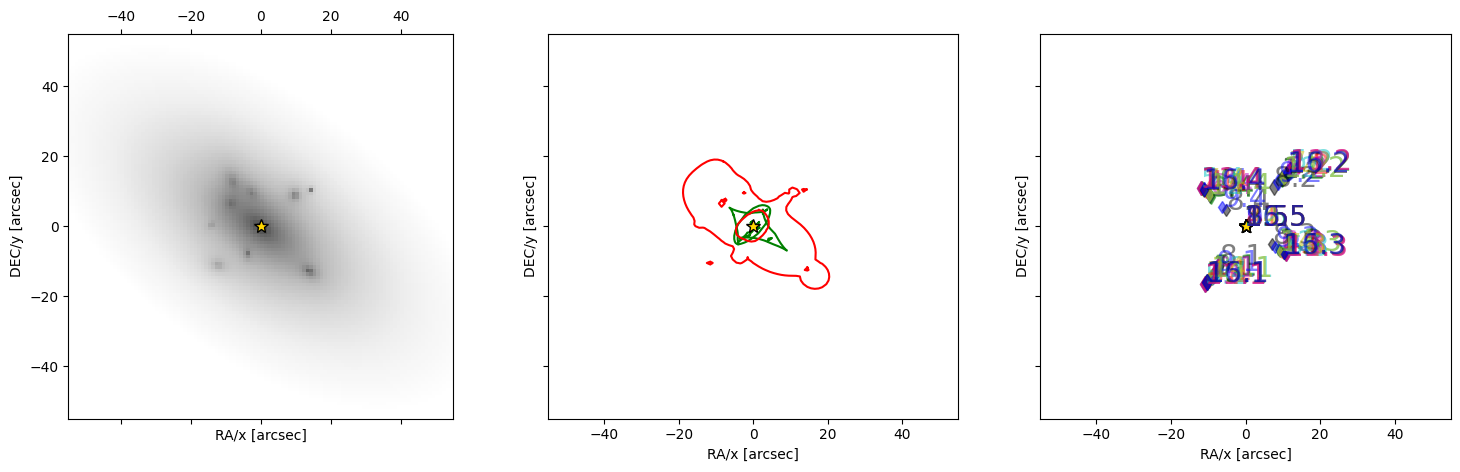

In [8]:
# # here we plot the lens model, including (optional) the caustics and critical curves

# Create figure and axes
f, ax = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

#Name_list = None  is the default, replace none with a list of strings (ex below) to have custom labels. When plotting, choose one of the lists, as shown below.
Name_list = [[".1", ".2", ".3", ".4", ".5", ".6", ".7", ".8", ".9", ".10", ".11", ".12", ".13", ".14", ".15", ".16", ".17", ".18", ".19", ".20"], ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]] # if using a custom Name_list, insert:  name_list=Name_list[i]  into the list of parameters for plotting.
num_Names = len(Name_list)
color_list = ['k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y'] # should be at least as long as the number of sources

lensModel.change_source_redshift(z_source=z_sources[0])
lens_plot.lens_model_plot(ax[0], lensModel=lensModel, kwargs_lens=kwargs_lens, images_x=[], images_y=[],
                          mag_images=None, index=0, color_value=color_list[0], name_list=Name_list[0], point_source=True,
                          images_from_data=False, with_caustics=False, numPix=110, deltaPix=1.0, with_convergence=True,
                          fontsize=5
                        )

rgba_transparent = (1.0, 1.0, 1.0, 0.0)
lens_plot.lens_model_plot(ax[1], lensModel=lensModel, kwargs_lens=kwargs_lens, images_x=[], images_y=[],
                          mag_images=None, index=0, color_value=color_list[0], name_list=Name_list[0], point_source=True,
                          images_from_data=False, with_caustics=True, numPix=110, deltaPix=1.0, with_convergence=False,
                          fontsize=5
                        )
for i in range(num_sources):
  lensModel.change_source_redshift(z_source=z_sources[i])
  lens_plot.lens_model_plot(ax[2], lensModel=lensModel, kwargs_lens=kwargs_lens, images_x=x_imgs[i], images_y=y_imgs[i], 
                          mag_images=mag_finites[i], index=i, color_value=color_list[i], name_list=Name_list[0], point_source=True,
                          images_from_data=False, with_caustics=False, numPix=110, deltaPix=1.0, with_convergence=False,
                          fontsize=5
                        )
# Show the plot
plt.show()

# kappa = lens.kappa(x_grid_rot, y_grid_rot, kwargs_lens)

In [ ]:
# Name_list = [[".1", ".2", ".3", ".4", ".5", ".6", ".7", ".8", ".9", ".10", ".11", ".12", ".13", ".14", ".15", ".16", ".17", ".18", ".19", ".20"], ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]] # if using a custom Name_list, insert:  name_list=Name_list[i]  into the list of parameters for plotting.
# num_Names = len(Name_list)
# color_list = ['k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y'] # should be at least as long as the number of sources

# # lensModel.change_source_redshift(z_source=z_sources[0])
# # lens_plot.lens_model_plot(plt, lensModel=lensModel, kwargs_lens=kwargs_lens, images_x=[], images_y=[],
# #                           mag_images=None, index=0, color_value=color_list[0], name_list=Name_list[0], point_source=True,
# #                           images_from_data=False, with_caustics=False, numPix=110, deltaPix=1.0, with_convergence=True,
# #                           fontsize=5
# #                         )

# f, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=False, sharey=False)

# lensModel.change_source_redshift(z_source=z_sources[0])
# lens_plot.lens_model_plot(ax, lensModel=lensModel, kwargs_lens=kwargs_lens, images_x=[], images_y=[],
#                           mag_images=None, index=0, color_value=color_list[0], name_list=Name_list[0], point_source=True,
#                           images_from_data=False, with_caustics=False, numPix=110, deltaPix=1.0, with_convergence=True,
#                           fontsize=5
#                         )

# rgba_transparent = (1.0, 1.0, 1.0, 0.0)
# lens_plot.lens_model_plot(ax, lensModel=lensModel, kwargs_lens=kwargs_lens, images_x=[], images_y=[],
#                           mag_images=None, index=0, color_value=color_list[0], name_list=Name_list[0], point_source=True,
#                           images_from_data=False, with_caustics=True, numPix=110, deltaPix=1.0, with_convergence=False,
#                           fontsize=5
#                         )


# for i in range(num_sources):
#   lensModel.change_source_redshift(z_source=z_sources[0])
#   lens_plot.lens_model_plot(ax, lensModel=lensModel, kwargs_lens=kwargs_lens, images_x=x_imgs[i], images_y=y_imgs[i],
#                           mag_images=None, index=i, color_value=color_list[i], name_list=Name_list[0], point_source=True,
#                           images_from_data=False, with_caustics=False, numPix=110, deltaPix=1.0, with_convergence=False,
#                           fontsize=5
#                         )
# f.show()


In [10]:
# Image properties
# this groups the images according to the sources that they came from, each list contains lists of the associated image ID's, positions, and redshifts. Used for plotting purposes.

grouped_ids = []
grouped_z_images = []
z_images = []

cutoff = 0
for i in range(num_sources):
    ids_temp = []
    z_temp = []
    for j in range(num_images_list[i]):
        ids_temp.append(image_ids[j+cutoff])
        z_temp = z_sources[i]*np.ones(num_images_list[i])
    cutoff += num_images_list[i]
    grouped_ids.append(ids_temp)
    grouped_z_images.append(z_temp)

print(grouped_ids)

[['1.1', '1.2', '1.3', '1.4', '1.5'], ['2.1', '2.2', '2.3'], ['3.1', '3.2', '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9'], ['4.1', '4.2', '4.3'], ['5.1', '5.2', '5.3'], ['6.1', '6.2', '6.3', '6.4', '6.5'], ['7.1', '7.2', '7.3', '7.4', '7.5'], ['8.1', '8.2', '8.3', '8.4', '8.5'], ['9.1', '9.2', '9.3', '9.4', '9.5'], ['10.1', '10.2', '10.3'], ['11.1', '11.2', '11.3', '11.4', '11.5'], ['12.1', '12.2', '12.3', '12.4', '12.5'], ['13.1', '13.2', '13.3'], ['14.1', '14.2', '14.3', '14.4', '14.5'], ['15.1', '15.2', '15.3', '15.4', '15.5'], ['16.1', '16.2', '16.3', '16.4', '16.5']]


C:\Users\earth\AppData\Local\Temp\ipykernel_22240\4053533408.py:49: RuntimeWarning: divide by zero encountered in log10
  ax.matshow(np.log10(image), vmin=0, vmax=5, origin='lower')


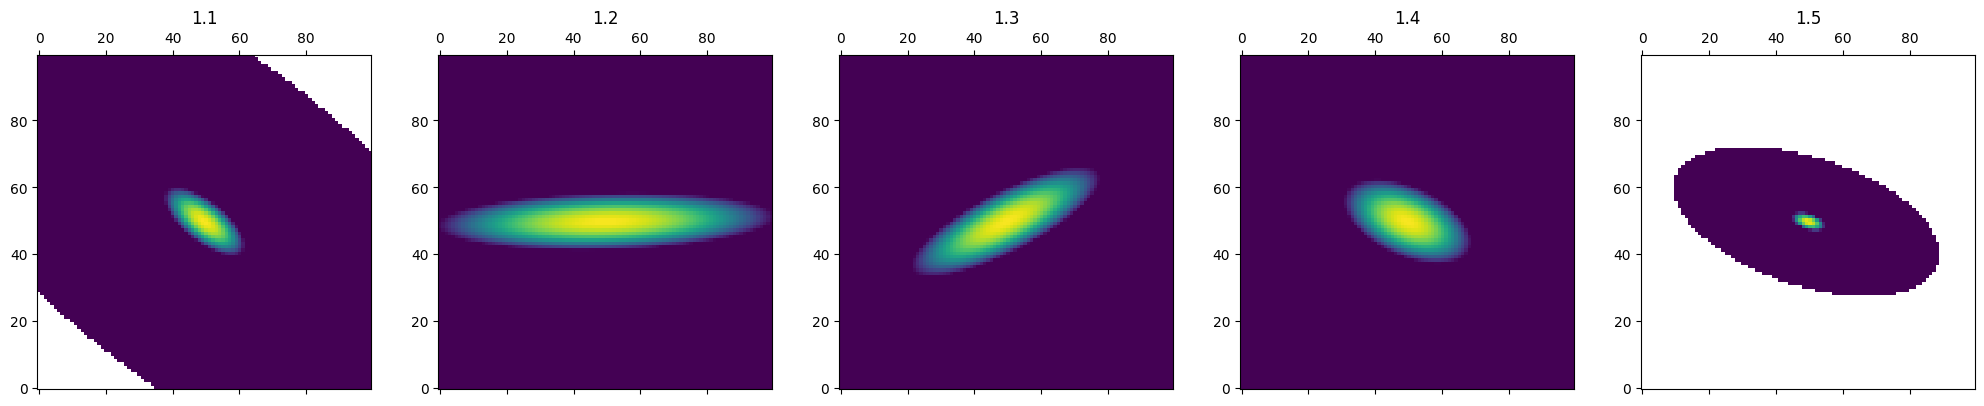

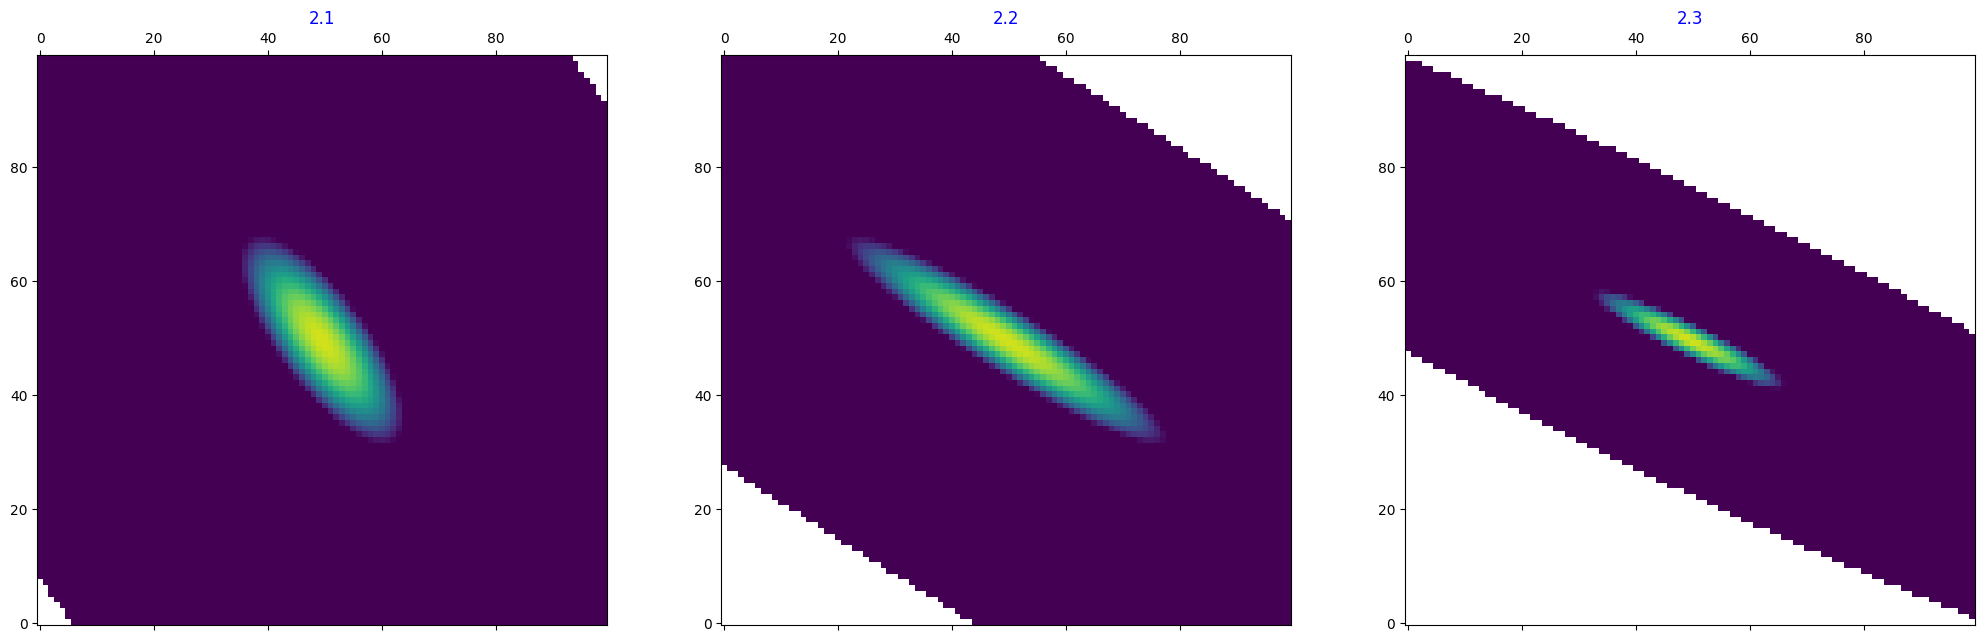

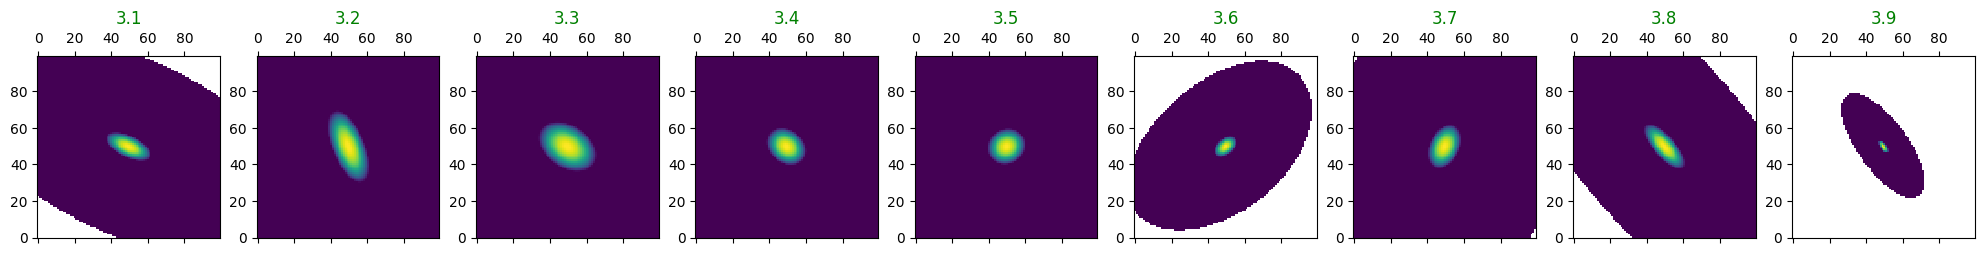

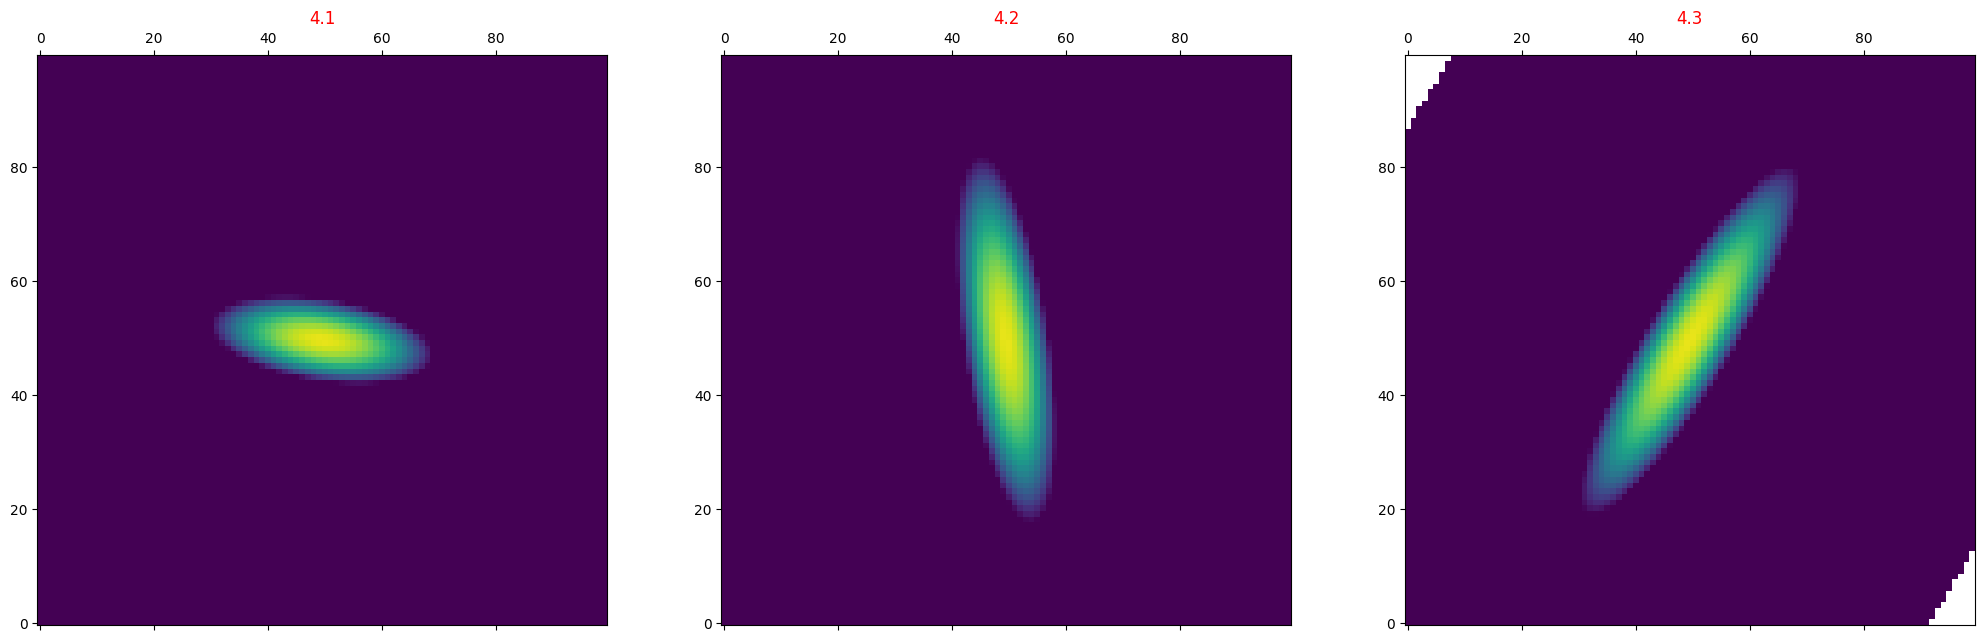

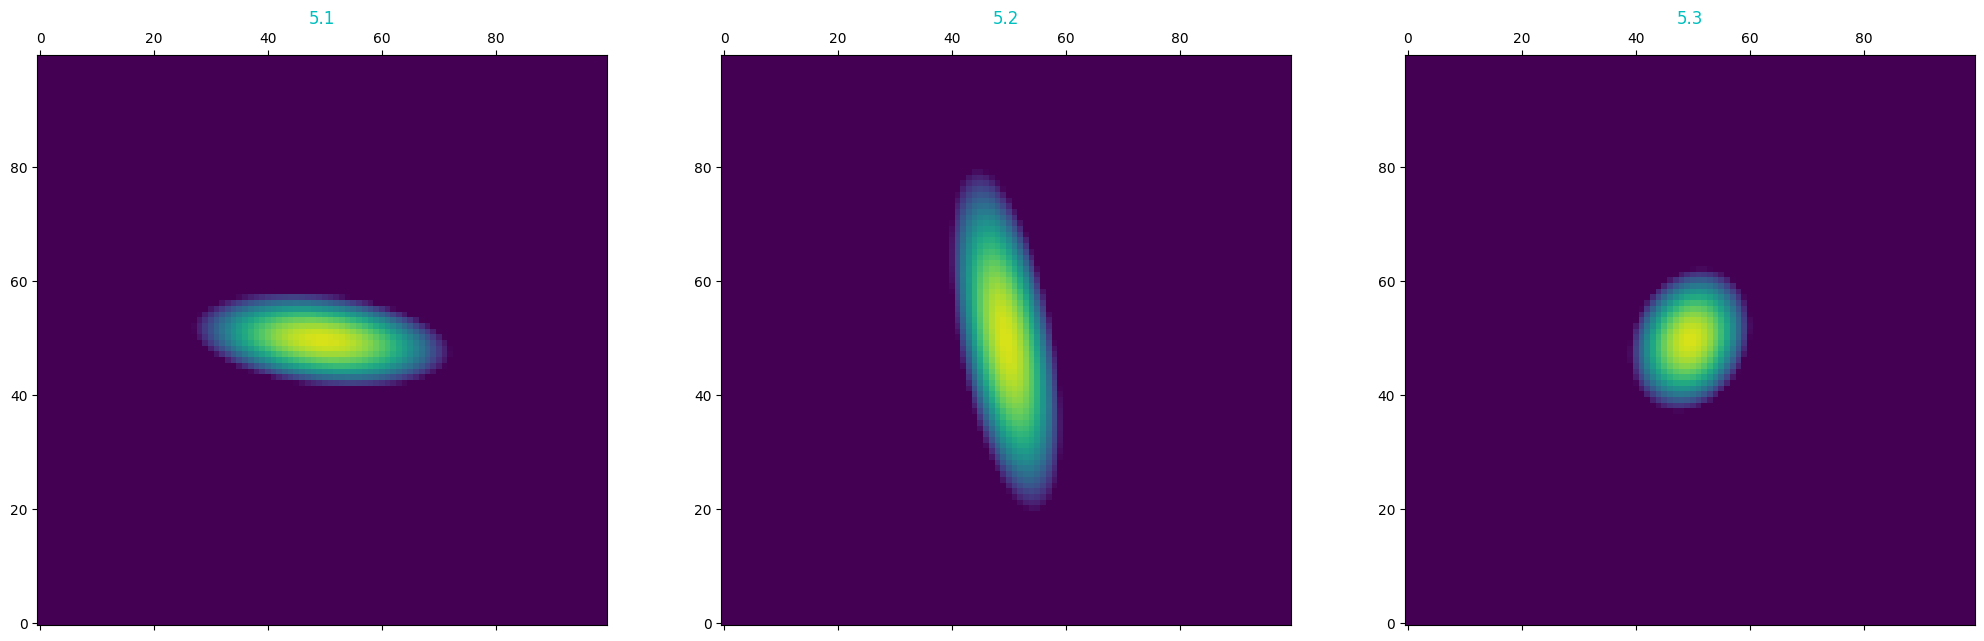

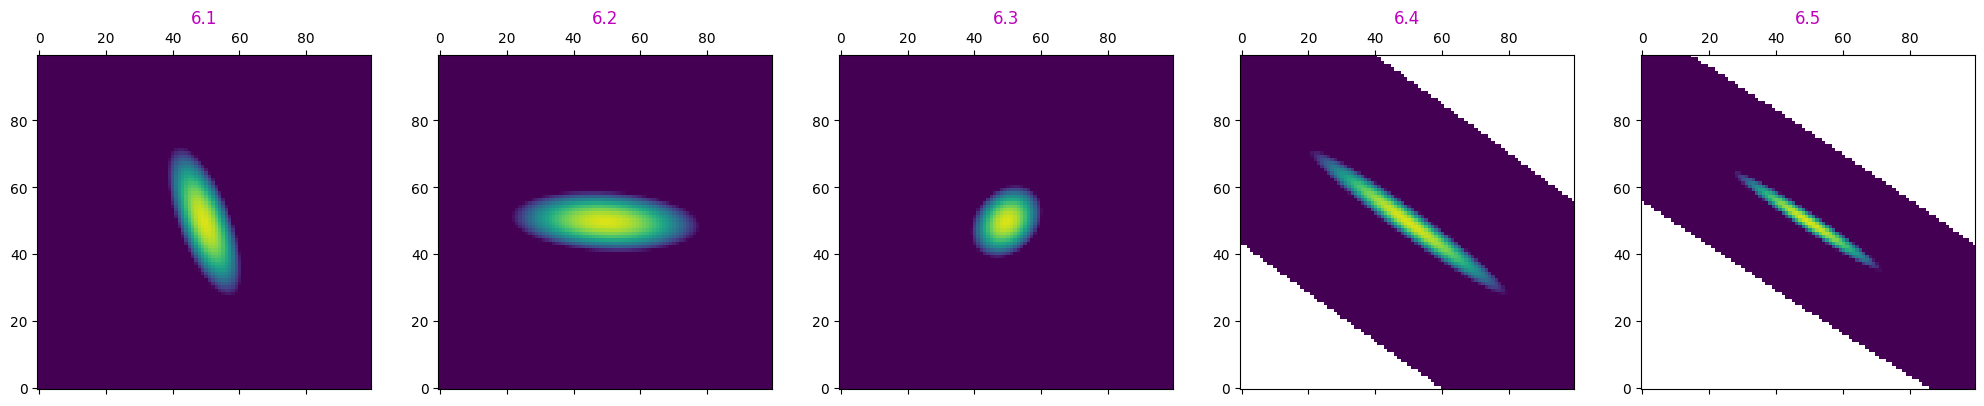

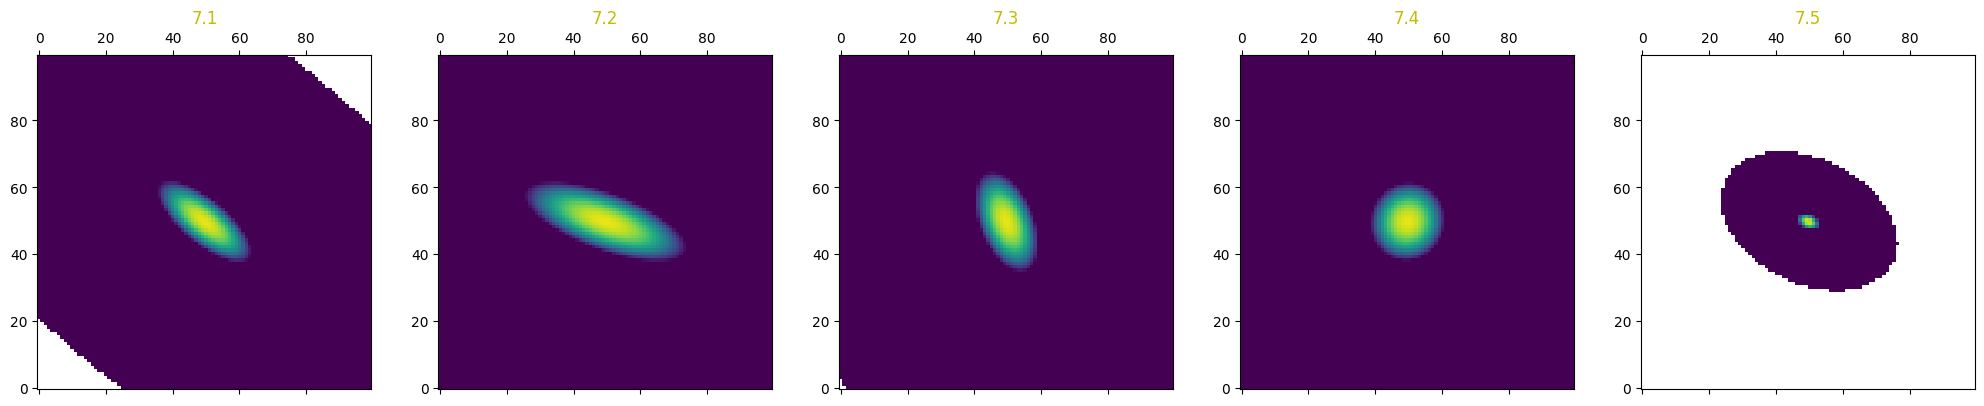

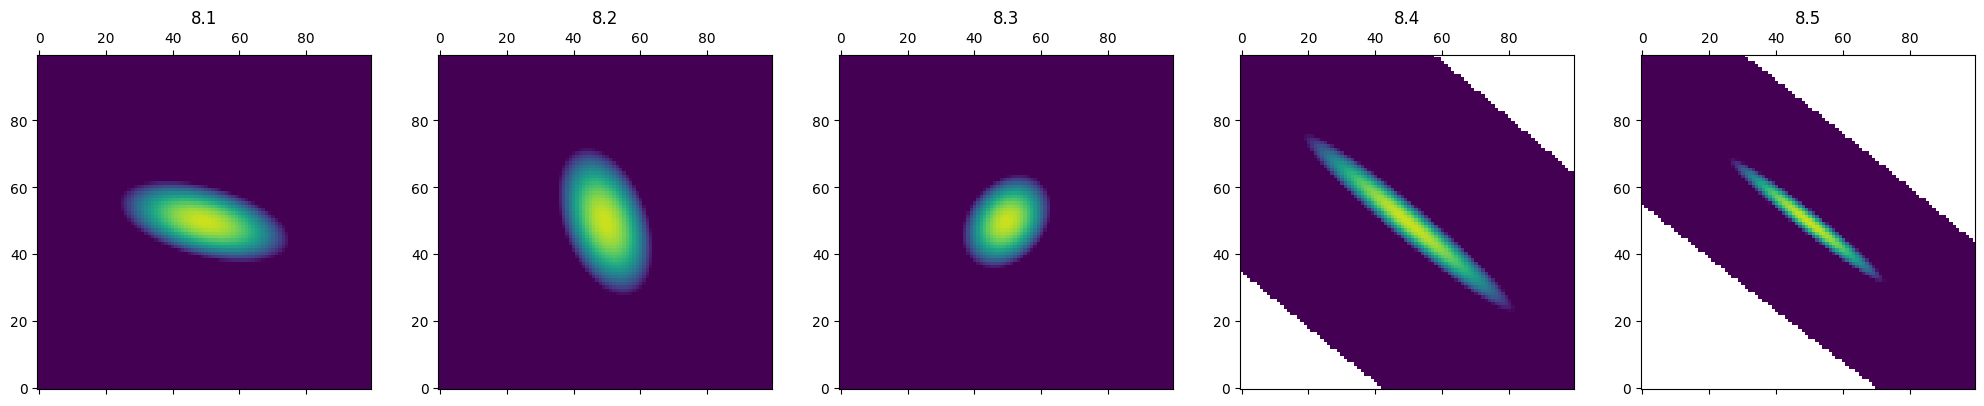

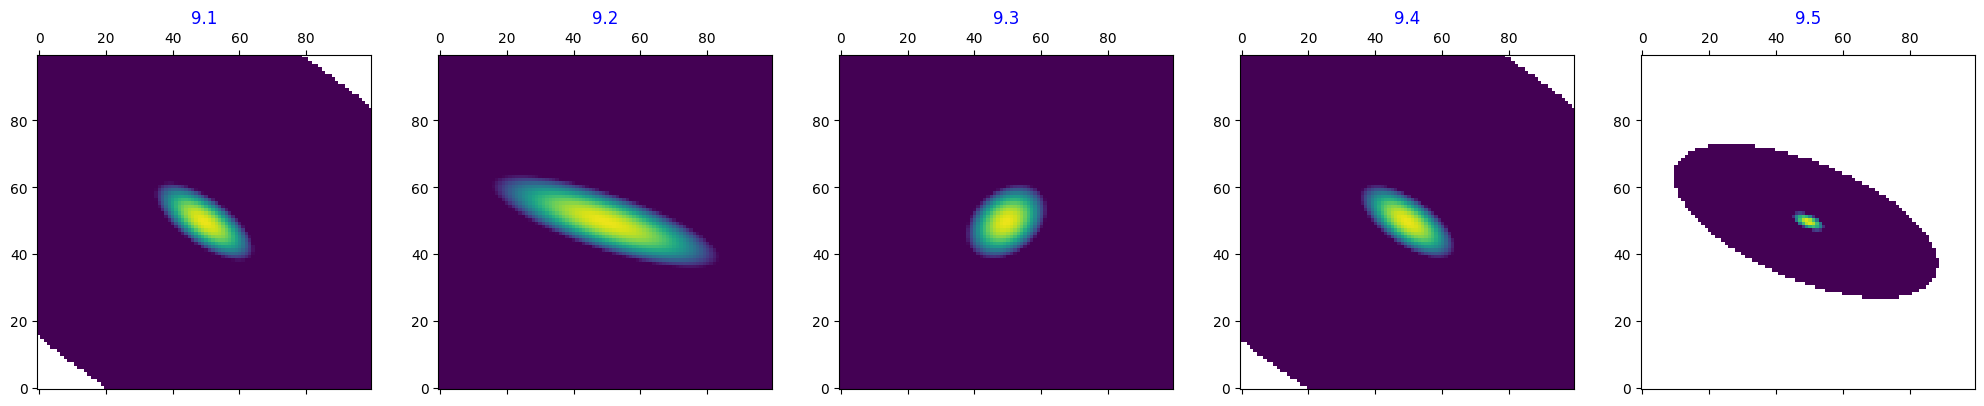

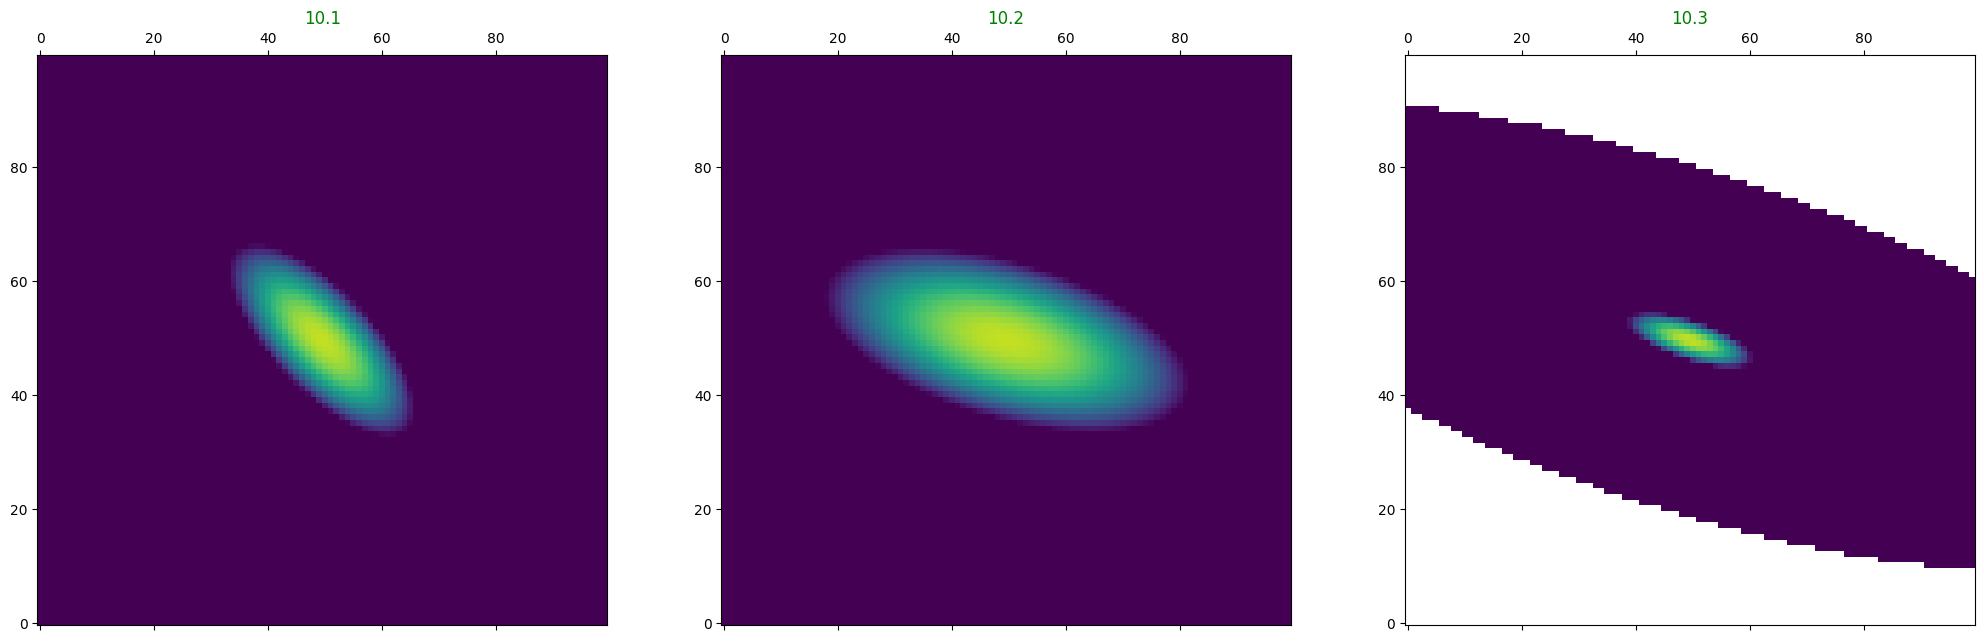

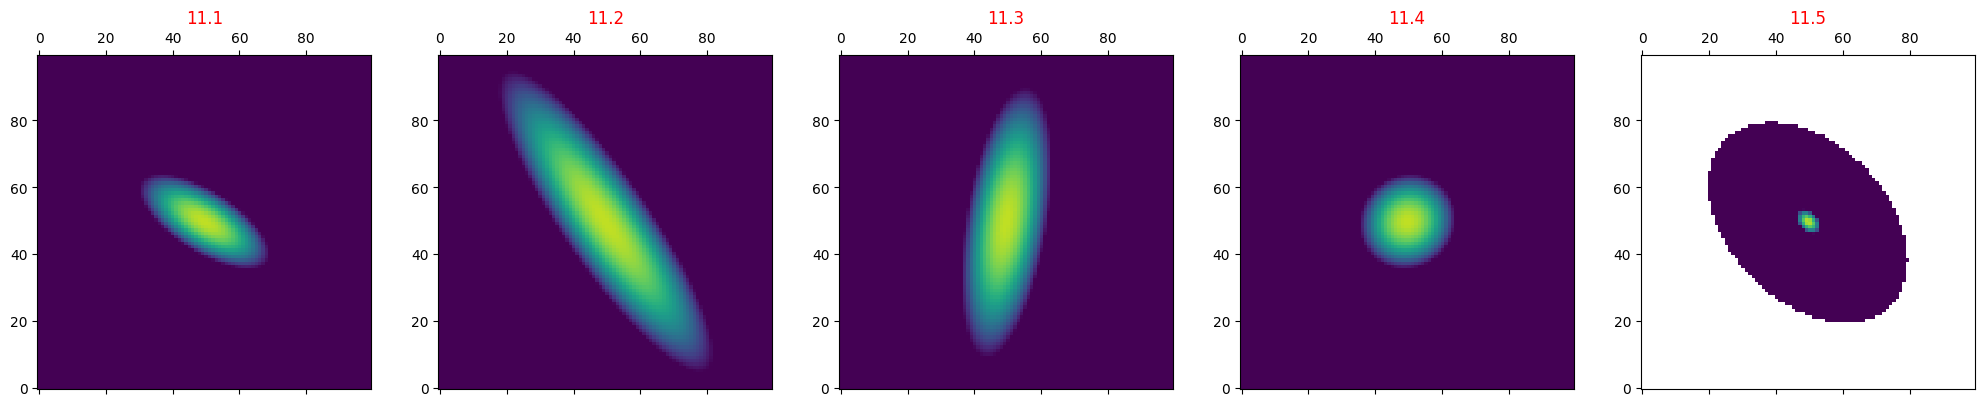

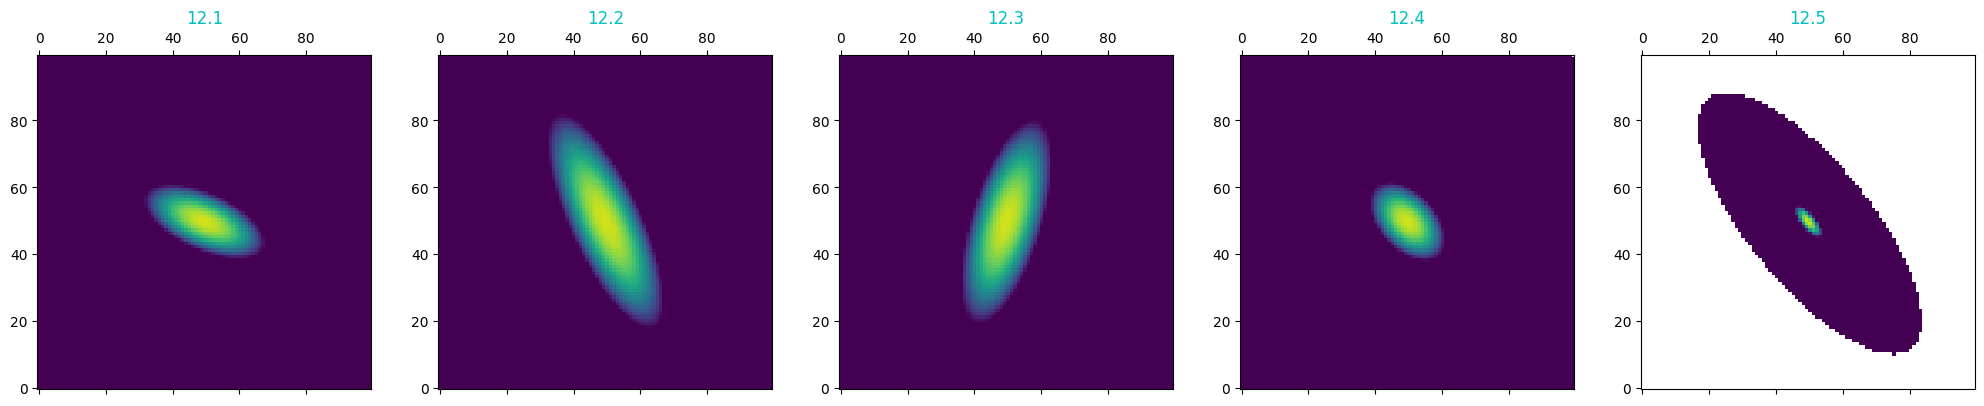

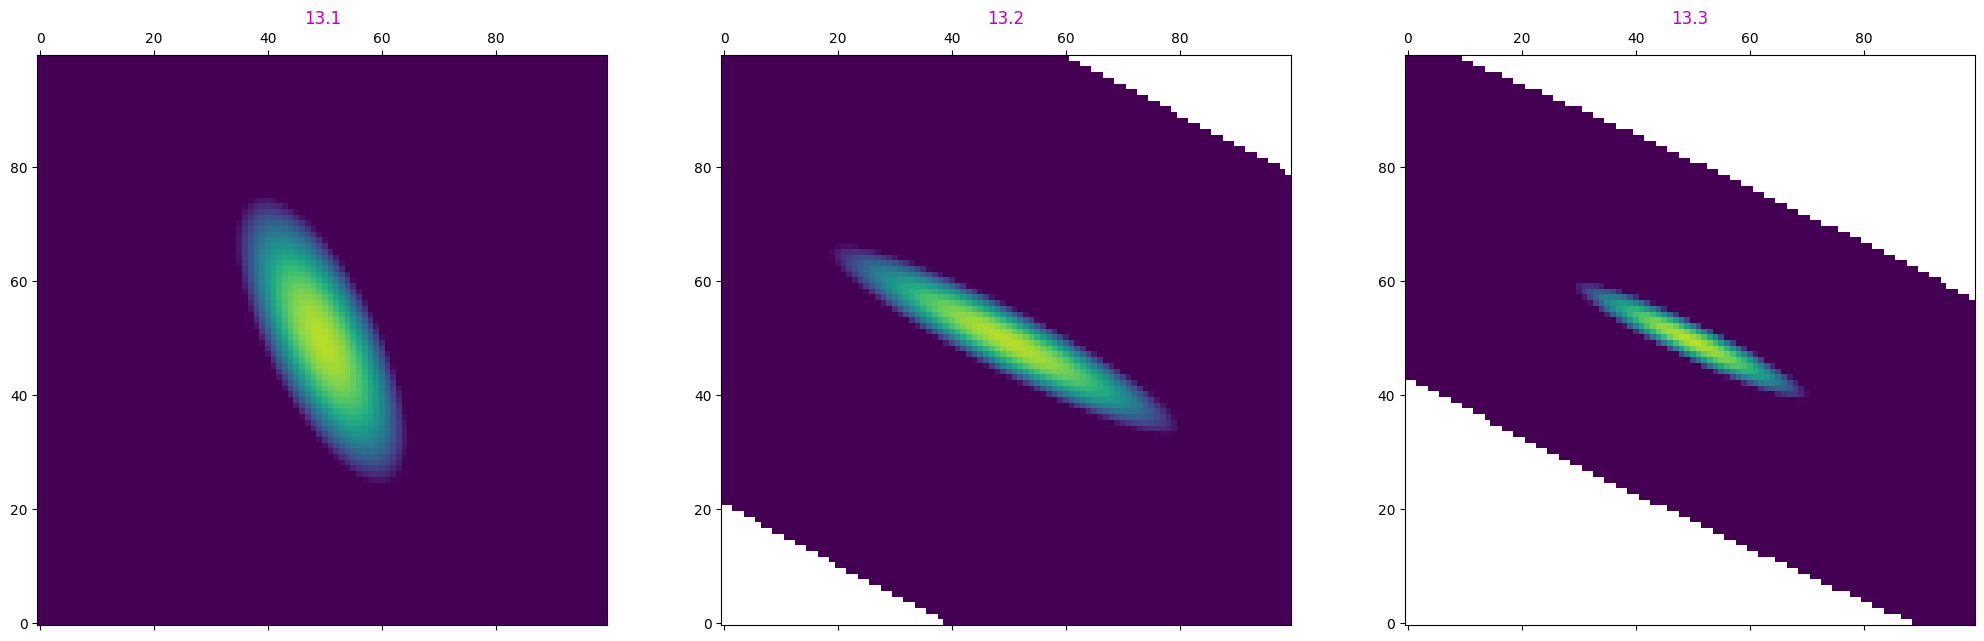

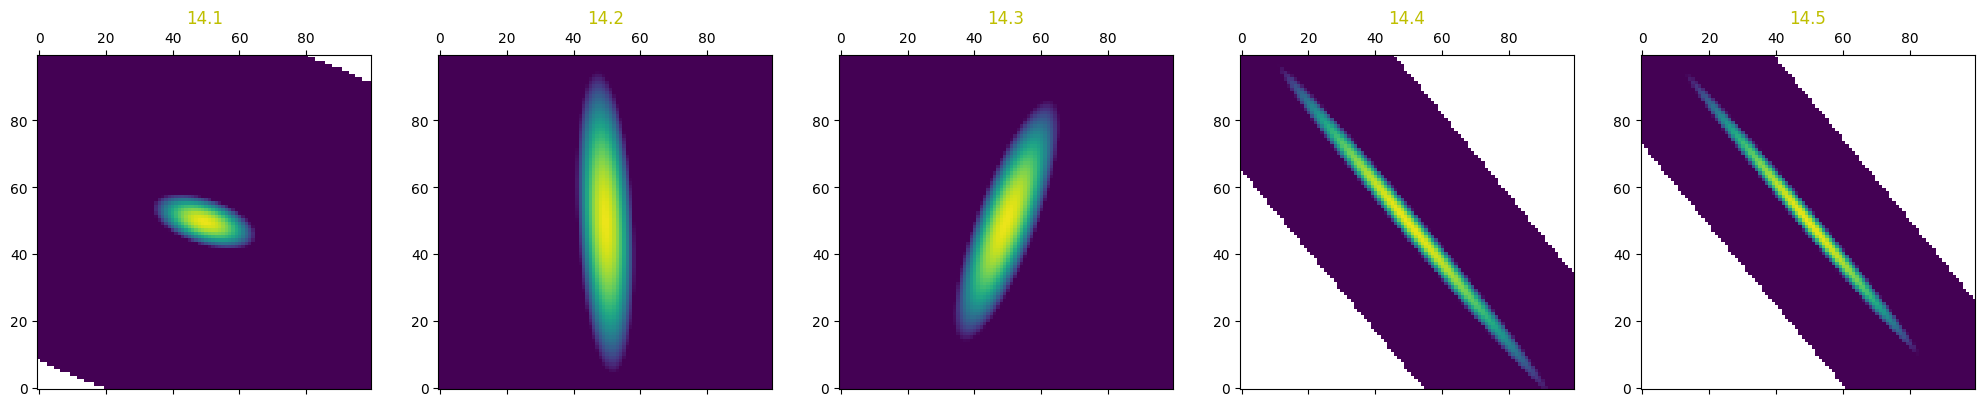

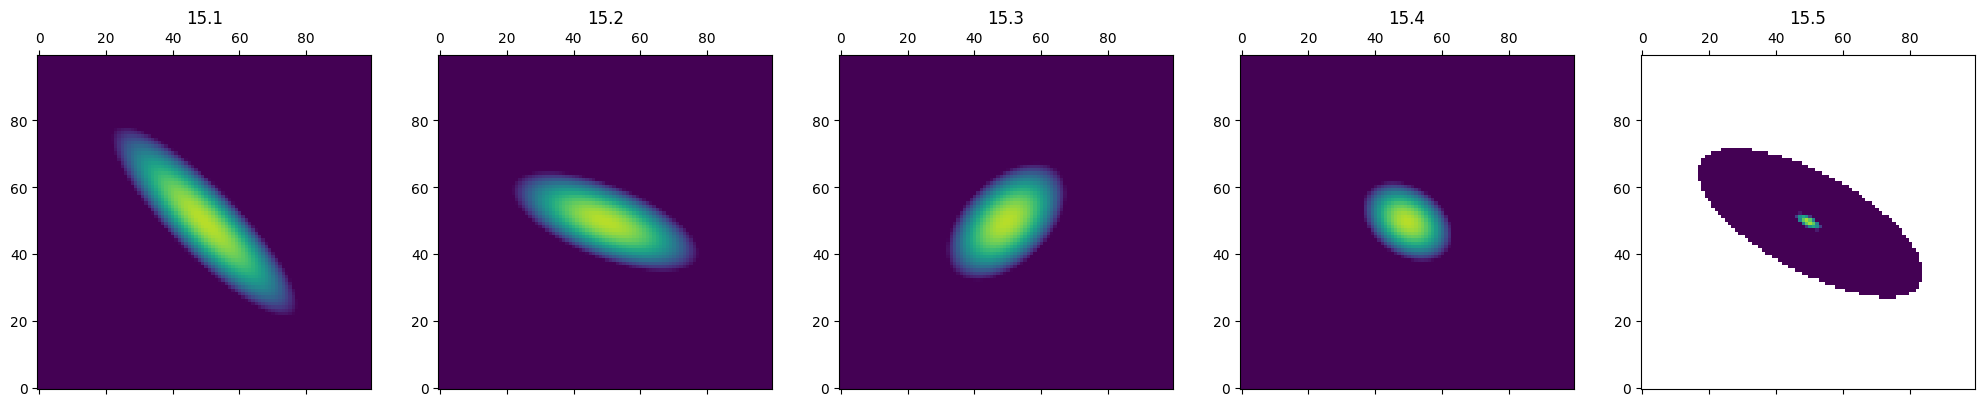

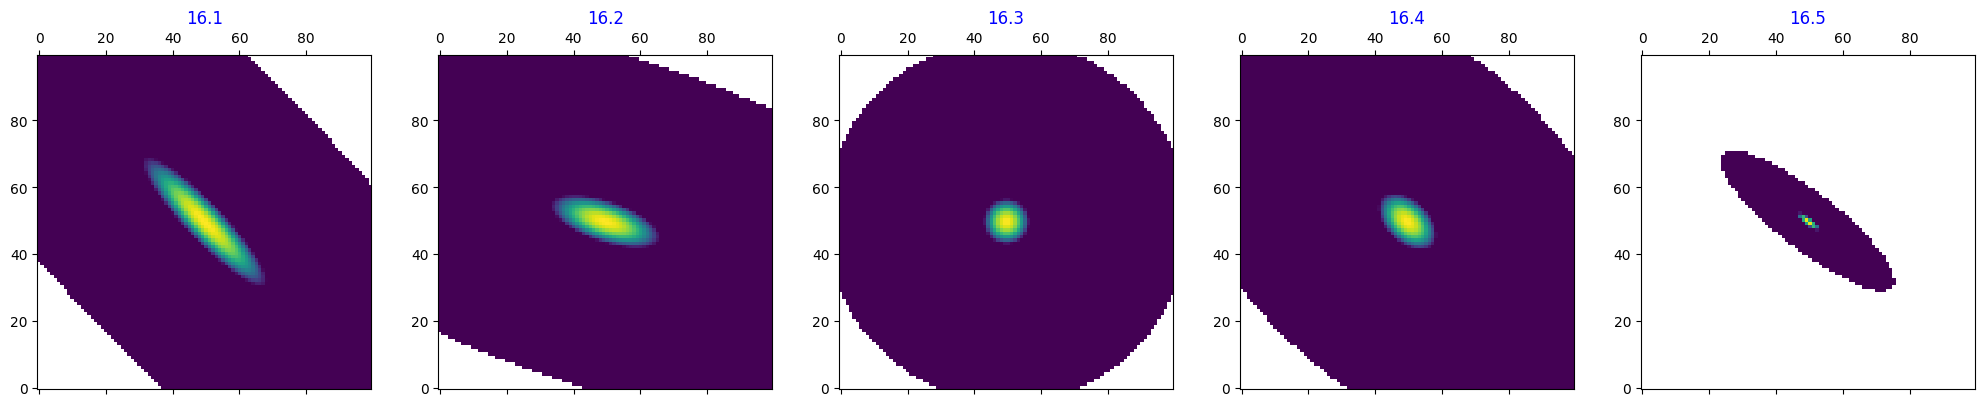

In [11]:
# here we plot the finite sources as seen at the different image positions
label_lists = []
for i in range(num_sources):
    label_list_temp = [None] * len(x_imgs[i])
    label_lists.append(label_list_temp)

if (Name_list is not None) & (num_Names == 1):
    for i in range(num_sources):
        lensModelExtensions._lensModel.change_source_redshift(z_source=z_sources[i])
        x_img_indexed = x_imgs[i]
        y_img_indexed = y_imgs[i]
        f, axes = plt.subplots(1, len(x_img_indexed), figsize=(5*5, 5*len(x_img_indexed)), sharex=False, sharey=False)
        for j in range(len(x_imgs[i])):
            label_lists[i][j] = grouped_ids[i][j]
        for k in range(len(x_img_indexed)):
            lensModelExtensions._lensModel.change_source_redshift(z_source=z_sources[i])
            image = lensModelExtensions.zoom_source(x_pos=x_img_indexed[k], y_pos=y_img_indexed[k], kwargs_lens=kwargs_lens, 
                                                            source_sigma=source_sizes_arcsec[i], window_size=window_size,
                                                            grid_number=grid_number)
            if len(x_img_indexed) == 1:
                axes.matshow(np.log10(image), vmin=0, vmax=5, origin='lower')
                axes.set_title(label_lists[i][k], color=color_list[i])
            else:
                ax = axes[k]
                ax.matshow(np.log10(image), vmin=0, vmax=5, origin='lower')
                ax.set_title(label_lists[i][k], color=color_list[i])
            # ax = axes[k]
            # ax.matshow(np.log10(image), vmin=0, vmax=5, origin='lower')
            # ax.set_title(label_lists[i][k], color=color_list[i])
        plt.show()
elif (Name_list is not None) & (num_Names > 1):
    for i in range(num_sources):
        lensModelExtensions._lensModel.change_source_redshift(z_source=z_sources[i])
        x_img_indexed = x_imgs[i]
        y_img_indexed = y_imgs[i]
        f, axes = plt.subplots(1, len(x_img_indexed), figsize=(5*5, 5*len(x_img_indexed)), sharex=False, sharey=False)
        for j in range(len(x_imgs[i])):
            label_lists[i][j] = grouped_ids[i][j]
        for k in range(len(x_img_indexed)):
            lensModelExtensions._lensModel.change_source_redshift(z_source=z_sources[i])
            image = lensModelExtensions.zoom_source(x_pos=x_img_indexed[k], y_pos=y_img_indexed[k], kwargs_lens=kwargs_lens, 
                                                            source_sigma=source_sizes_arcsec[i], window_size=window_size,
                                                            grid_number=grid_number)
            if len(x_img_indexed) == 1:
                axes.matshow(np.log10(image), vmin=0, vmax=5, origin='lower')
                axes.set_title(label_lists[i][k], color=color_list[i])
            else:
                ax = axes[k]
                ax.matshow(np.log10(image), vmin=0, vmax=5, origin='lower')
                ax.set_title(label_lists[i][k], color=color_list[i])
            # ax = axes[k]
            # ax.matshow(np.log10(image), vmin=0, vmax=5, origin='lower')
            # ax.set_title(label_lists[i][k], color=color_list[i])
            
        plt.show()
else:
    for i in range(num_sources):
        x_img_indexed = x_imgs[i]
        y_img_indexed = y_imgs[i]
        f, axes = plt.subplots(1, len(x_img_indexed), figsize=(5*5, 5*len(x_img_indexed)), sharex=False, sharey=False)
        label_list = [f"{i+1}A", f"{i+1}B", f"{i+1}C", f"{i+1}D", f"{i+1}E", f"{i+1}F", f"{i+1}G", f"{i+1}H", f"{i+1}I", f"{i+1}J", f"{i+1}K"]
        for j in range(len(x_img_indexed)):
            lensModelExtensions._lensModel.change_source_redshift(z_source=z_sources[i])
            image = lensModelExtensions.zoom_source(x_pos=x_img_indexed[i], y_pos=y_img_indexed[i], kwargs_lens=kwargs_lens, 
                                                            source_sigma=source_sizes_arcsec[j], window_size=window_size,
                                                            grid_number=grid_number)
            if len(x_img_indexed) == 1:
                axes.matshow(np.log10(image), vmin=0, vmax=5, origin='lower')
                axes.set_title(label_lists[i][j], color=color_list[i])
            else:
                ax = axes[j]
                ax.matshow(np.log10(image), vmin=0, vmax=5, origin='lower')
                ax.set_title(label_lists[i][j], color=color_list[i])
            # ax = axes[i]
            # ax.matshow(np.log10(image), vmin=0, vmax=5, origin='lower')
            # ax.set_title(label_list[i], color=color_list[i])
        plt.show()

## Set up data for modeling
Now that we have read in all our data and completed the necessary calculations, we can explicitly set up the data in the way we want to use for modeling.
This includes set up of the uncertainty for each value, including flux ratios, time delays, and image positions.

In this section, we explicitly set up the data products that we want to use for the modeling. You can replace this box with the values for the lens you want to model.

In [ ]:
## Here we calculate the flux ratio between the different images from the same source. We then also add a sigma to the values to account for error

flux_error = 0.02              # flux ratio error based on the Mahler et al. paper
flux_ratios_list = []
flux_ratio_errors_list = []
flux_ratios_measured_list = []

for i in range(num_sources):
    lensModel.change_source_redshift(z_source=z_sources[0])
    if len(mag_infs[i]) <= 1:
        flux_ratios = []
        flux_ratios_measured = []
        flux_ratio_errors = []
    else:
        image_amps = np.abs(mag_infs[i])
        flux_ratios = image_amps[1:]/image_amps[0]
        flux_ratio_errors = flux_error*np.ones(len(flux_ratios))
        flux_ratios_measured = flux_ratios + np.random.normal(0, flux_ratio_errors)
        if measurement_realization:
            flux_ratios_measured = flux_ratios + np.random.normal(0, flux_ratio_errors)
        else:
            flux_ratios_measured = flux_ratios
    flux_ratios_list.append(flux_ratios)
    flux_ratio_errors_list.append(flux_ratio_errors)
    flux_ratios_measured_list.append(flux_ratios_measured)
print('flux_ratios_list: %s' %(flux_ratios_list))

# image positions in relative RA (arc seconds)
astrometry_sigma = 0.005  # 1-sigma astrometric uncertainties of the image positions (assuming equal precision for all images in RA/DEC directions)

## Here we loop to calculate the time delays
d_dts = []
d_dt_sigmas = []
d_dt_measured_list = []
ximg_measured_list = []
yimg_measured_list = []

for i in range(num_sources):
    if len(t_days[i]) <= 1:
        d_dt_measured = []
    else:
        d_dt = t_days[i][1:] - t_days[i][0]  # lenstronomy definition of relative time delay is in respect of first image in the list (full covariance is in planning)
        d_dt_sigma = 0.5 * np.ones(len(d_dt))
        d_dts.append(d_dt)
        d_dt_sigmas.append(d_dt_sigma)
        
        if measurement_realization:
            d_dt_measured = d_dt + np.random.normal(0, d_dt_sigma)
        else:
            d_dt_measured = d_dt
            
    if measurement_realization:    
        ximg_measured = x_imgs[i] + np.random.normal(0, astrometry_sigma, len(x_imgs[i]))
        yimg_measured = y_imgs[i] + np.random.normal(0, astrometry_sigma, len(y_imgs[i]))
    else:
        ximg_measured = x_imgs[i]
        yimg_measured = y_imgs[i]
    
    d_dt_measured_list.append(d_dt_measured)
    ximg_measured_list.append(ximg_measured)
    yimg_measured_list.append(yimg_measured)

# here we create a keyword list with all the data elements. If you only have partial information about your lens, only provide the quantities you have.
# kwargs_time_delays_list = []
# kwargs_time_delay_uncertainties_list = []
# kwargs_flux_ratios_list = []
# kwargs_flux_ratio_errors_list = []
kwargs_ra_image_list = []
kwargs_dec_image_list = []


for i in range(num_sources):
    # kwargs_time_delays_list.append(d_dt_measured_list[i])
    # kwargs_time_delay_uncertainties_list.append(d_dt_sigmas[i])
    # kwargs_flux_ratios_list.append(flux_ratios_measured_list[i])
    # kwargs_flux_ratio_errors_list.append(flux_ratio_errors_list[i])
    kwargs_ra_image_list.append(ximg_measured_list[i])
    kwargs_dec_image_list.append(yimg_measured_list[i])

kwargs_data_joint = {'ra_image_list': kwargs_ra_image_list, 'dec_image_list': kwargs_dec_image_list}
    #                  'time_delays_measured': kwargs_time_delays_list,
    #                  'time_delays_uncertainties': kwargs_time_delay_uncertainties_list,
    #                  'flux_ratios': kwargs_flux_ratios_list, 
    #                  'flux_ratio_errors': kwargs_flux_ratio_errors_list,
    # don't add this:  'point_source_redshift_list': z_sources_new}

# print("time delay measured", kwargs_data_joint["time_delays_measured"])
# print('ra kwargs: %s \ndec kwargs: %s' %(kwargs_ra_image_list, kwargs_dec_image_list))

flux_ratios_list: [array([4.86553074, 3.20825089, 2.39976194, 0.13914263]), array([1.05342351, 0.32389271]), array([2.28389813, 2.50960739, 1.31065662, 1.25838737, 0.3893625 ,
       1.27744749, 1.12908579, 0.08884872]), array([1.72544364, 1.88623479]), array([1.38670537, 0.71881258]), array([1.35859305, 0.59792442, 0.81384018, 0.38709224]), array([1.89025375, 1.10328845, 1.12791773, 0.06696097]), array([1.05487233, 0.65128184, 0.76476275, 0.34530991]), array([2.48200395, 1.04303876, 0.95208496, 0.09024353]), array([2.38620114, 0.21232589]), array([3.43724495, 2.42699042, 0.99746551, 0.05690163]), array([2.25787465, 2.02325169, 0.70967365, 0.07671182]), array([0.71960509, 0.27839031]), array([3.41082951, 3.10352676, 1.95575709, 1.39362762]), array([0.84397142, 0.71113439, 0.3953941 , 0.01964236]), array([0.72250658, 0.31365919, 0.44931736, 0.02992104])]


## Model settings
Here we set up the modeling. For each lens mass and the dark matter halo, a new instance of the initial guess of the parameters, uncertainties and lower and upper bounds must be included, each added to the appropriate kwargs dictionary. These values should match what is used in the lensing profiles that were chosen.
In this example, we use the same lens model as we chose earlier to generate the plots, etc. In the pure modeling notebook, as we choose the same lens model for both, we might expect a perfect fit. However, with real data, this is less likely.

This part is equal to the imaging simulation of lenstronomy. We refer to other notebooks and the documentation for more details: https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/LensModeling/modelling_of_catalogue_data.ipynb.

In [13]:
# ==================
# lens model choices
# ==================
# could also add things that are known very well to the fixed_lens.append({}) list, ie. this could be not empty!

### for Setting the galaxy lens parameters
# combine the append of all these at the same time as the lens_model_list

## fix the relative scaling of one deflector and another
# mass_scaling = False  # if True, samples scaling parameters
# num_scale_factor = 1  # number of scaling parameters being sampled

# mass_scaling_list = []  # False or integer for each mass model, integer, model theta_E gets multiplied with the saling parameter[integer - 1]
# for i in range(num_cluster_members):
#     mass_scaling_list.append(1)
# mass_scaling_list.append(False)

## we have previously defined our lens_model_list as we needed it for calculations/plotting above. If not defined above, uncomment it below.
# lens_model_list = []
# for i in range(len(gal_data_arcsec)):
#     lens_model_list.append('PJAFFE_ELLIPSE_POTENTIAL')
# lens_model_list.append('NFW_ELLIPSE_CSE')

## fixed_lens values here
fixed_lens = []
for i in range(num_cluster_members):
    # fixed_lens.append({})
    fixed_lens.append({'sigma0': sigma0s[i], "e1": e1s[i], "e2": e2s[i], 'Ra': Ras[i], 'Rs': Rss[i], 'center_x': x_cluster_members[i], "center_y": y_cluster_members[i]})
fixed_lens.append({"Rs": nfw_Rs, "alpha_Rs": nfw_alpha_Rs, "e1": nfw_e1, "e2": nfw_e2, "center_x": nfw_x, "center_y": nfw_y})
# fixed_lens.append({})

kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

# SPEMD parameters
# for i in range(len(lens_model_list)):
#     fixed_lens.append({})

# append once for each of the cluster members, then once for the dark matter halo
for i in range(num_cluster_members):
    # initial parameter guess
    kwargs_lens_init.append({'sigma0': sigma0s[i], "e1": e1s[i], "e2": e2s[i], 'Ra': Ras[i], 'Rs': Rss[i], 'center_x': x_cluster_members[i], "center_y": y_cluster_members[i]})
    # initial particle cloud
    kwargs_lens_sigma.append({'sigma0': 0.01, 'e1': 0.01, 'e2': 0.01, 'Ra': 1.0, 'Rs': 17, 'center_x': 0.1, 'center_y': 0.1})
    # hard lower bound limit of parameters
    kwargs_lower_lens.append({'sigma0': 0, 'e1': -0.5, 'e2': -0.5, 'Ra': 0, 'Rs': 0, 'center_x': -100, 'center_y': -100})
    # hard upper bound limit of parameters
    kwargs_upper_lens.append({'sigma0': 1000, 'e1': 0.5, 'e2': 0.5, 'Ra': 100, 'Rs': 100, 'center_x': 100, 'center_y': 100})

# same kwargs but for the nfw dark matter halo
kwargs_lens_init.append({"Rs": nfw_Rs, "alpha_Rs": nfw_alpha_Rs, "e1": nfw_e1, "e2": nfw_e2, "center_x": nfw_x, "center_y": nfw_y})
kwargs_lens_sigma.append({"Rs": 0.1, "alpha_Rs": 0.1, "e1": 0.01, "e2": 0.01, "center_x": 0.01 , "center_y": 0.01})
kwargs_lower_lens.append({"Rs": 0, "alpha_Rs": 0, "e1": -0.5, "e2": -0.5, "center_x": -100, "center_y": -100})
kwargs_upper_lens.append({"Rs": 10000, "alpha_Rs": 1000, "e1": 0.5, "e2": 0.5, "center_x": 100, "center_y": 100})

# SHEAR parameters
# we keep the center of shear definition fixed at (0,0). Want to make sure that things aren't moving, they're just being sheared?
# for i in range(len(lens_model_list)):
    # fixed_lens.append({'ra_0': 0, 'dec_0': 0})
    # kwargs_lens_init.append({'gamma1': 0.0, 'gamma2': 0.0})
    # kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
    # kwargs_lower_lens.append({'gamma1': -0.3, 'gamma2': -0.3})
    # kwargs_upper_lens.append({'gamma1': 0.3, 'gamma2': 0.3})

# combine all parameter options for lenstronomy
lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]
print('kwargs_lens_init len: %s, data: %s' %(len(kwargs_lens_init), kwargs_lens_init))
print('fixed_lens len: %s, data: %s' %(len(fixed_lens), fixed_lens))
print('kwargs_lens_sigma_list len: %s, data: %s' %(len(kwargs_lens_sigma), kwargs_lens_sigma))
print('kwargs_lower_lens_list len: %s, data: %s' %(len(kwargs_lower_lens), kwargs_lower_lens))
print('kwargs_upper_lens_list len: %s, data: %s' %(len(kwargs_upper_lens), kwargs_upper_lens))

kwargs_lens_init len: 11, data: [{'sigma0': 1.6692528302621406, 'e1': -0.005963408814306501, 'e2': 0.028987851267885584, 'Ra': 0.14304486684040685, 'Rs': 1.2392323340379334, 'center_x': 14.350432185244088, 'center_y': 10.507883203188516}, {'sigma0': 1.6123234300962002, 'e1': -0.019381253240776858, 'e2': 0.00389378054598169, 'Ra': 0.3109810179929473, 'Rs': 5.446534280757485, 'center_x': 9.864069865313613, 'center_y': 9.084495076292722}, {'sigma0': 0.832609131993273, 'e1': -0.027495130819679095, 'e2': -0.00043695108768342095, 'Ra': 0.7377212185003087, 'Rs': 4.888959751509585, 'center_x': -8.274476193873594, 'center_y': 6.7747609852849635}, {'sigma0': 0.4356712373068588, 'e1': 0.05504092392155169, 'e2': -0.039701154589705405, 'Ra': 0.9584017571471027, 'Rs': 5.858424003261759, 'center_x': -12.062407619149372, 'center_y': -10.894292312232903}, {'sigma0': 19.329534879379587, 'e1': -0.09616365720698761, 'e2': -0.014049996143097293, 'Ra': 0.0158259658431944, 'Rs': 3.0125643439316905, 'center_x

Now we do the same for the image parameters, including an initial guess, uncertainty, and upper and lower limits for each instance. This is also where we can choose to include 'special' parameters, such as astrometric perturbations, time delay distances, or quasar soruce information if relevant.
We can choose here to fix the x and y position parameters if desired, removing one degree of freedom from our model.

In [14]:
# =========================
# image position parameters
# =========================

# we chose to model the image positions in the lensed plane (we know where they appear) and fix the image position coordinates
point_source_list = []
fixed_ps = []
kwargs_ps_init = []
kwargs_ps_sigma = []
kwargs_lower_ps = []
kwargs_upper_ps = []

for i in range(num_sources):
    point_source_list.append('LENSED_POSITION')
    # fixed_ps.append({'ra_image': ximg_measured_list[i], 'dec_image': yimg_measured_list[i]})  # we fix the image position coordinates
    fixed_ps.append({})
    kwargs_ps_init.append({'ra_image': ximg_measured_list[i], 'dec_image': yimg_measured_list[i]})
    kwargs_ps_sigma.append({'ra_image': 0.01 * np.ones(len(x_imgs[i])), 'dec_image': 0.01 * np.ones(len(y_imgs[i]))})
    kwargs_lower_ps.append({'ra_image': -100 * np.ones(len(x_imgs[i])), 'dec_image': -100 * np.ones(len(y_imgs[i]))})
    kwargs_upper_ps.append({'ra_image': 100* np.ones(len(x_imgs[i])), 'dec_image': 100 * np.ones(len(y_imgs[i]))})

# combine all parameter options for lenstronomy
ps_params = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]

fixed_special = {}
kwargs_special_init = {}
kwargs_special_sigma = {}
kwargs_lower_special = {}
kwargs_upper_special = {}

# =========================
# astrometric perturbations
# =========================
# astrometric perturbations are modeled in lenstronomy with 'delta_x_image' and 'delta_y_image'.
# These perturbations place the 'actual' point source at the difference to 'ra_image'.
# we let some freedom in how well the actual image positions are matching those given by the data (indicated as 'ra_image', 'dec_image' and held fixed while fitting)

#kwargs_special_init['delta_x_image'], kwargs_special_init['delta_y_image'] = np.zeros_like(ximg), np.zeros_like(yimg)
#kwargs_special_sigma['delta_x_image'], kwargs_special_sigma['delta_y_image'] = np.ones_like(ximg) * astrometry_sigma, np.ones_like(yimg) * astrometry_sigma
#kwargs_lower_special['delta_x_image'], kwargs_lower_special['delta_y_image'] = np.ones_like(ximg) * (-1), np.ones_like(yimg) * (-1)
#kwargs_upper_special['delta_x_image'], kwargs_upper_special['delta_y_image'] = np.ones_like(ximg) * (1), np.ones_like(yimg) * (1)

# ==================
# quasar source size
# ==================
# # If you want to keep the source size fixed during the fitting, don't comment the line below (or comment the line to let it vary).
# fixed_special['source_size'] = [source_size_arcsec, source_size_arcsec2]
# kwargs_special_init['source_size'] = [source_size_arcsec, source_size_arcsec2]
# kwargs_special_sigma['source_size'] = [source_size_arcsec, source_size_arcsec2]
# or:
# kwargs_special_init['source_size'] = source_sizes_arcsec[0]
# kwargs_special_sigma['source_size'] = source_sizes_arcsec[0]
# fixed_special['source_size'] = source_sizes_arcsec[0]

# kwargs_lower_special['source_size'] = 0.0001
# kwargs_upper_special['source_size'] = 1


# ===================
# Time-delay distance
# ===================
# with time-delay information, we can measure the time-delay distance (units physical Mpc)

# if you want to fix the cosmology and instead use the time-delay information to constrain the lens model, out-comment the line below
    # essentially, choose either the first line of the above block of code, or the first line of the below block of code
#fixed_special['D_dt'] = lensCosmo.D_dt
# kwargs_special_init['D_dt'] = lensCosmo.ddt
# kwargs_special_sigma['D_dt'] = 2000
# kwargs_lower_special['D_dt'] = 0
# kwargs_upper_special['D_dt'] = 10000

# mass scaling parameter configuraiton
kwargs_special_init['scale_factor'] = [1]       #### Does this get replaced with the mass scaling relationships from the calculations above?
kwargs_special_sigma['scale_factor'] = [0.2]
kwargs_lower_special['scale_factor'] = [0]
kwargs_upper_special['scale_factor'] = [10]

special_params = [kwargs_special_init, kwargs_special_sigma, fixed_special, kwargs_lower_special, kwargs_upper_special]
print("special_params:", special_params)

# combined parameter settings
kwargs_params = {'lens_model': lens_params,
                'point_source_model': ps_params,
                'special': special_params}

# our model choices
kwargs_model = {'lens_model_list': lens_model_list, 
                'point_source_model_list': point_source_list,
                'point_source_redshift_list': z_sources,           # add this for changing redshifts of sources!
                'z_source_convention': z_source_convention,
                'z_lens': z_lens_nfw,
                'cosmo': cosmo}

print("point_source_list:", point_source_list)
print("fixed_lens:", fixed_lens)
print("fixed_ps:", fixed_ps)
print("fixed_special:", fixed_special)
print("kwargs_special_init:", kwargs_special_init)

special_params: [{'scale_factor': [1]}, {'scale_factor': [0.2]}, {}, {'scale_factor': [0]}, {'scale_factor': [10]}]
point_source_list: ['LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION']
fixed_lens: [{'sigma0': 1.6692528302621406, 'e1': -0.005963408814306501, 'e2': 0.028987851267885584, 'Ra': 0.14304486684040685, 'Rs': 1.2392323340379334, 'center_x': 14.350432185244088, 'center_y': 10.507883203188516}, {'sigma0': 1.6123234300962002, 'e1': -0.019381253240776858, 'e2': 0.00389378054598169, 'Ra': 0.3109810179929473, 'Rs': 5.446534280757485, 'center_x': 9.864069865313613, 'center_y': 9.084495076292722}, {'sigma0': 0.832609131993273, 'e1': -0.027495130819679095, 'e2': -0.00043695108768342095, 'Ra': 0.7377212185003087, 'Rs': 4.888959751509585,

## setup options for likelihood and parameter sampling
In $\texttt{lenstronomy}$ the likelihood settings (which likelihood gets evaluated) and the parameter sampling options (which parameters get sampled) are separated. It is upon the user to decide the appropriate parameters to be sampled for the given choice of likelihood and information.

In [15]:
# so I'd have to turn these on or off depending on what model/information I have
time_delay_likelihood = False     # bool, set this True or False depending on whether time-delay information is available and you want to make use of its information content.
flux_ratio_likelihood = False     # bool, modeling the flux ratios of the images
image_position_likelihood = True  # bool, evaluating the image position likelihood (in combination with astrometric errors)

kwargs_flux_compute = {'source_type': 'INF',        # you can either chose 'INF' which is a infinetesimal source size, 'GAUSSIAN' or 'TORUS'
                       'window_size': window_size,  # window size to compute the finite source magnification (only when 'GAUSSIAN' or 'TORUS' are chosen.)
                       'grid_number': grid_number}  # number of grid points (per axis) to compute the extended source surface brightness within the window_size around the image position

kwargs_constraints = {'num_point_source_list': num_images_list,
                        # 'Ddt_sampling': time_delay_likelihood,
                      'mass_scaling_list': mass_scaling_list
                      } # sampling of the time-delay distance

# ATTENTION: make sure that the numerical options are chosen to provide accurate computations for the finite source magnifications!
if kwargs_flux_compute['source_type'] in ['GAUSSIAN', 'TORUS'] and flux_ratio_likelihood is True:
    kwargs_constraints['source_size'] = True  # explicit sampling of finite source size parameter (only use when source_type='GAUSSIAN' or 'TORUS')

# we can define un-correlated Gaussian priors on specific parameters explicitly
# e.g. power-law mass slope of the main deflector
# prior_lens = [[0, 'center_x', 0, 0.01], [0, 'center_y', 0, 0.01]] # [[0, 'gamma', 2, 0.1],[index_model, 'param_name', mean, 1-sigma error], [...], ...]
# e.g. source size of the emission region
# prior_lens_light = []
# prior_special = []
    
kwargs_likelihood = {'image_position_uncertainty': astrometry_sigma,  # astrometric uncertainty of image positions
                     'image_position_likelihood': True,               # evaluate point source likelihood given the measured image positions
                     'time_delay_likelihood': False,                  # evaluating the time-delay likelihood
                     'flux_ratio_likelihood': False,                  # enables the flux ratio likelihood 
                     'kwargs_flux_compute': kwargs_flux_compute,      # source_type='INF' will lead to point source
                    # 'prior_lens': prior_lens,
                    # 'prior_lens_light': prior_lens_light,
                    # 'prior_special': prior_special,
                     'check_bounds': True                            # check parameter bounds and punish them
                    }

## Multiple image position constraints
Matching multiple image position constraints from the same source is a difficult and computationally tedious task. Here we discuss a few different approaches, their pros and cons and how they are implemented in lenstronomy. You can find more on these methods in another notebook: https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/LensModeling/modelling_of_catalogue_data.ipynb.

In [16]:
# setting the non-linear solver accoring to option (3)
kwargs_constraints['solver_type'] = 'NONE'  # 'PROFILE_SHEAR', 'NONE', # any proposed lens model must satisfy the image positions appearing at the position of the point sources being sampeled

# checking for matched source position in ray-tracing the image position back to the source plane.
# This flag should be set =True when dealing with option (2) and (3)
# kwargs_likelihood['check_matched_source_position'] = True  # check non-linear solver and discard non-solutions # removed by simon in a recent PR
kwargs_likelihood['source_position_tolerance'] = 15  # hard bound tolerance on r.m.s. scatter in the source plane to be met in the sampling

# desired precision on r.m.s. scatter in the source plane to achive. 
# This is implemented as a Gaussian likelihood term and is met when the model is sufficient in describing the data
# This precision must be set when using option (2). Option (3) should guarantee a very high precision except in some failures of the solver.
kwargs_likelihood['source_position_sigma'] = astrometry_sigma

# setting to propagate the astrometric uncertainties in image position into a likelihood in the source position.
# Option (4) above. This option can be used SEPARATE to the solver or the source position tolerance (see below)
# Care has to be taken when requiring time-delay predictions.
kwargs_likelihood['source_position_likelihood'] = True  # evaluates how close the different image positions match the source positons]
kwargs_likelihood['image_position_uncertainty'] = astrometry_sigma  # this option (4) uses the 'image_position_uncertainty' to translate to a source position uncertainty (see also Birrer & Treu 2019)

## log_likelihood test

In [17]:
from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

kwargs_truth = {"kwargs_ps": kwargs_ps_init, "kwargs_lens": kwargs_lens_init, "kwargs_source": {}, "kwargs_special": kwargs_special_init,
                "kwargs_lens_light": None, "kwargs_tracer_source": None}
log_likelihood = fitting_seq.likelihoodModule.log_likelihood(kwargs_truth, verbose=True)

args = fitting_seq.param_class.kwargs2args(**kwargs_truth)
kwargs_test = fitting_seq.param_class.args2kwargs(args)
print(kwargs_test)
kwargs_ps_test = kwargs_test['kwargs_ps']
for kwargs in kwargs_ps_test:
    print(kwargs)

fitting_seq.likelihoodModule.logL(args, verbose=True)

print(log_likelihood)

Prior likelihood = 0
source position likelihood -102.52822679080461
image position likelihood 0.0
{'kwargs_lens': [{'sigma0': np.float64(1.6692528302621406), 'Ra': 0.14304486684040685, 'Rs': 1.2392323340379334, 'e1': -0.005963408814306501, 'e2': 0.028987851267885584, 'center_x': 14.350432185244088, 'center_y': 10.507883203188516}, {'sigma0': np.float64(1.6123234300962002), 'Ra': 0.3109810179929473, 'Rs': 5.446534280757485, 'e1': -0.019381253240776858, 'e2': 0.00389378054598169, 'center_x': 9.864069865313613, 'center_y': 9.084495076292722}, {'sigma0': np.float64(0.832609131993273), 'Ra': 0.7377212185003087, 'Rs': 4.888959751509585, 'e1': -0.027495130819679095, 'e2': -0.00043695108768342095, 'center_x': -8.274476193873594, 'center_y': 6.7747609852849635}, {'sigma0': np.float64(0.4356712373068588), 'Ra': 0.9584017571471027, 'Rs': 5.858424003261759, 'e1': 0.05504092392155169, 'e2': -0.039701154589705405, 'center_x': -12.062407619149372, 'center_y': -10.894292312232903}, {'sigma0': np.float

## Distance and Root Mean Square Error calculations of the source positions

In [18]:
func_x_source, func_y_source = fitting_seq.likelihoodModule.PointSource.source_position(kwargs_ps_init, kwargs_lens)

func_diffs_x, func_diffs_y = fitting_seq.likelihoodModule._position_likelihood.source_position_dist(kwargs_ps=kwargs_ps_init, kwargs_lens=kwargs_lens, lens_model=lensModel, z_sources=z_sources)
print('Distances (x): %s' %(func_diffs_x))
print('Distances (y): %s' %(func_diffs_y))

func_rmse_x, func_rmse_y = fitting_seq.likelihoodModule._position_likelihood.source_position_rmse(kwargs_ps=kwargs_ps_init, kwargs_lens=kwargs_lens, lens_model=lensModel, z_sources=z_sources)
print('RMSE (x, y): %s, %s' %(func_rmse_x, func_rmse_y))

Distances (x): [array([ 5.18878064e-05,  1.37776680e-04,  2.34001214e-03,  4.42596063e-04,
       -2.97227269e-03]), array([ 0.00556051, -0.00455106, -0.00100945]), array([-0.00132966, -0.00382315,  0.00274908,  0.00206257, -0.00087143,
       -0.00155477,  0.00304929, -0.00045659,  0.00017466]), array([-0.00140601, -0.00268725,  0.00409326]), array([ 0.00172186,  0.00512127, -0.00684313]), array([-0.00041158,  0.00236235,  0.00213478, -0.00152534, -0.00256022]), array([-0.00431911, -0.0013164 , -0.00508121,  0.00374344,  0.00697327]), array([ 0.00051029,  0.00208064, -0.0019221 ,  0.00618462, -0.00685346]), array([ 0.00045012, -0.00292321, -0.00122206, -0.00244678,  0.00614193]), array([-0.00061578,  0.00079086, -0.00017509]), array([ 0.00207476,  0.00255633, -0.00143777,  0.00180606, -0.00499938]), array([ 9.69515376e-05,  7.06670545e-04, -1.69009865e-03,  1.75220737e-04,
        7.11255826e-04]), array([-0.00757571, -0.0005644 ,  0.0081401 ]), array([ 0.00214828, -0.00230845, -0.001

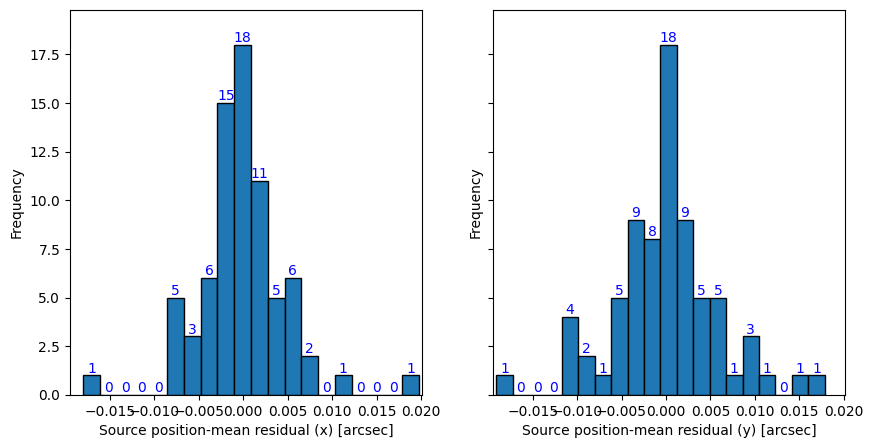

In [21]:
f, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

x_data = []
y_data = []

for i in range(len(func_diffs_x)):
    for j in range(len(func_diffs_x[i])):
        x_data.append(func_diffs_x[i][j])
        y_data.append(func_diffs_y[i][j])

values_x, bins_x, bars_x = ax[0].hist(x_data, bins=20, edgecolor='black')
values_y, bins_y, bars_y = ax[1].hist(y_data, bins=20, edgecolor='black')

ax[0].set_ylabel('Frequency')
ax[1].set_ylabel('Frequency')

ax[0].set_xlabel('Source position-mean residual (x) [arcsec]')
ax[1].set_xlabel('Source position-mean residual (y) [arcsec]')

ax[0].bar_label(bars_x, fontsize=10, color='blue')
ax[1].bar_label(bars_y, fontsize=10, color='blue')

ax[0].margins(x=0.01, y=0.1)
ax[1].margins(x=0.01, y=0.1)

ax[0].set_title('')
ax[1].set_title('')

plt.show()

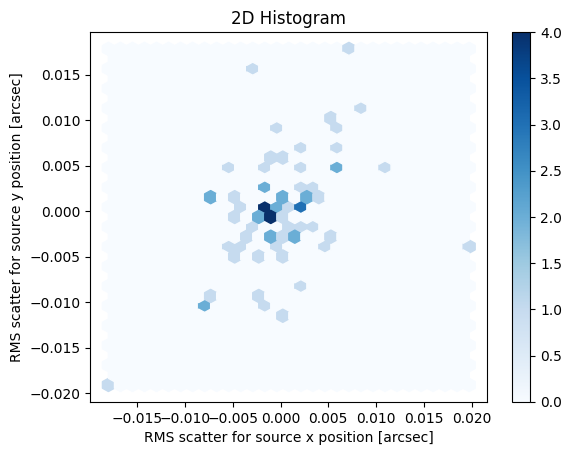

In [22]:
plt.hexbin(x_data, y_data, gridsize=30, cmap='Blues')
plt.xlabel('RMS scatter for source x position [arcsec]')
plt.ylabel('RMS scatter for source y position [arcsec]')
plt.title('2D Histogram')
plt.colorbar()

plt.show()

## Run the modeling - Particle Swarm Optimization to find a maxima in the likelihood

In [ ]:
fitting_kwargs_list = [['PSO', {'sigma_scale': .1, 'n_particles': 100, 'n_iterations': 200}]] #['update_settings', {'lens_add_fixed': [[0, ['gamma']]]}]]
    # you can add additional fixed parameters in the line above if you want

start_time = time.time()
chain_list_pso = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATIONS, YOUR JOB WAS SUCCESSFUL ================ ')

Computing the PSO ...


 12%|█▏        | 24/200 [09:13<1:07:02, 22.86s/it]

In [85]:
fitting_seq.best_fit_likelihood(verbose=True)

Prior likelihood = 0
source position likelihood -4.289222842658091e-15
image position likelihood 0.0


np.float64(-4.289222842658091e-15)

Prior likelihood = 0
source position likelihood -4.289222842658091e-15
image position likelihood 0.0
kwargs_results {'kwargs_lens': [{'sigma0': np.float64(1.6692528302621406), 'Ra': 0.14304486684040685, 'Rs': 1.2392323340379334, 'e1': -0.005963408814306501, 'e2': 0.028987851267885584, 'center_x': 14.350432185244088, 'center_y': 10.507883203188516}, {'sigma0': np.float64(1.6123234300962002), 'Ra': 0.3109810179929473, 'Rs': 5.446534280757485, 'e1': -0.019381253240776858, 'e2': 0.00389378054598169, 'center_x': 9.864069865313613, 'center_y': 9.084495076292722}, {'sigma0': np.float64(0.832609131993273), 'Ra': 0.7377212185003087, 'Rs': 4.888959751509585, 'e1': -0.027495130819679095, 'e2': -0.00043695108768342095, 'center_x': -8.274476193873594, 'center_y': 6.7747609852849635}, {'sigma0': np.float64(0.4356712373068588), 'Ra': 0.9584017571471027, 'Rs': 5.858424003261759, 'e1': 0.05504092392155169, 'e2': -0.039701154589705405, 'center_x': -12.062407619149372, 'center_y': -10.894292312232903}, {

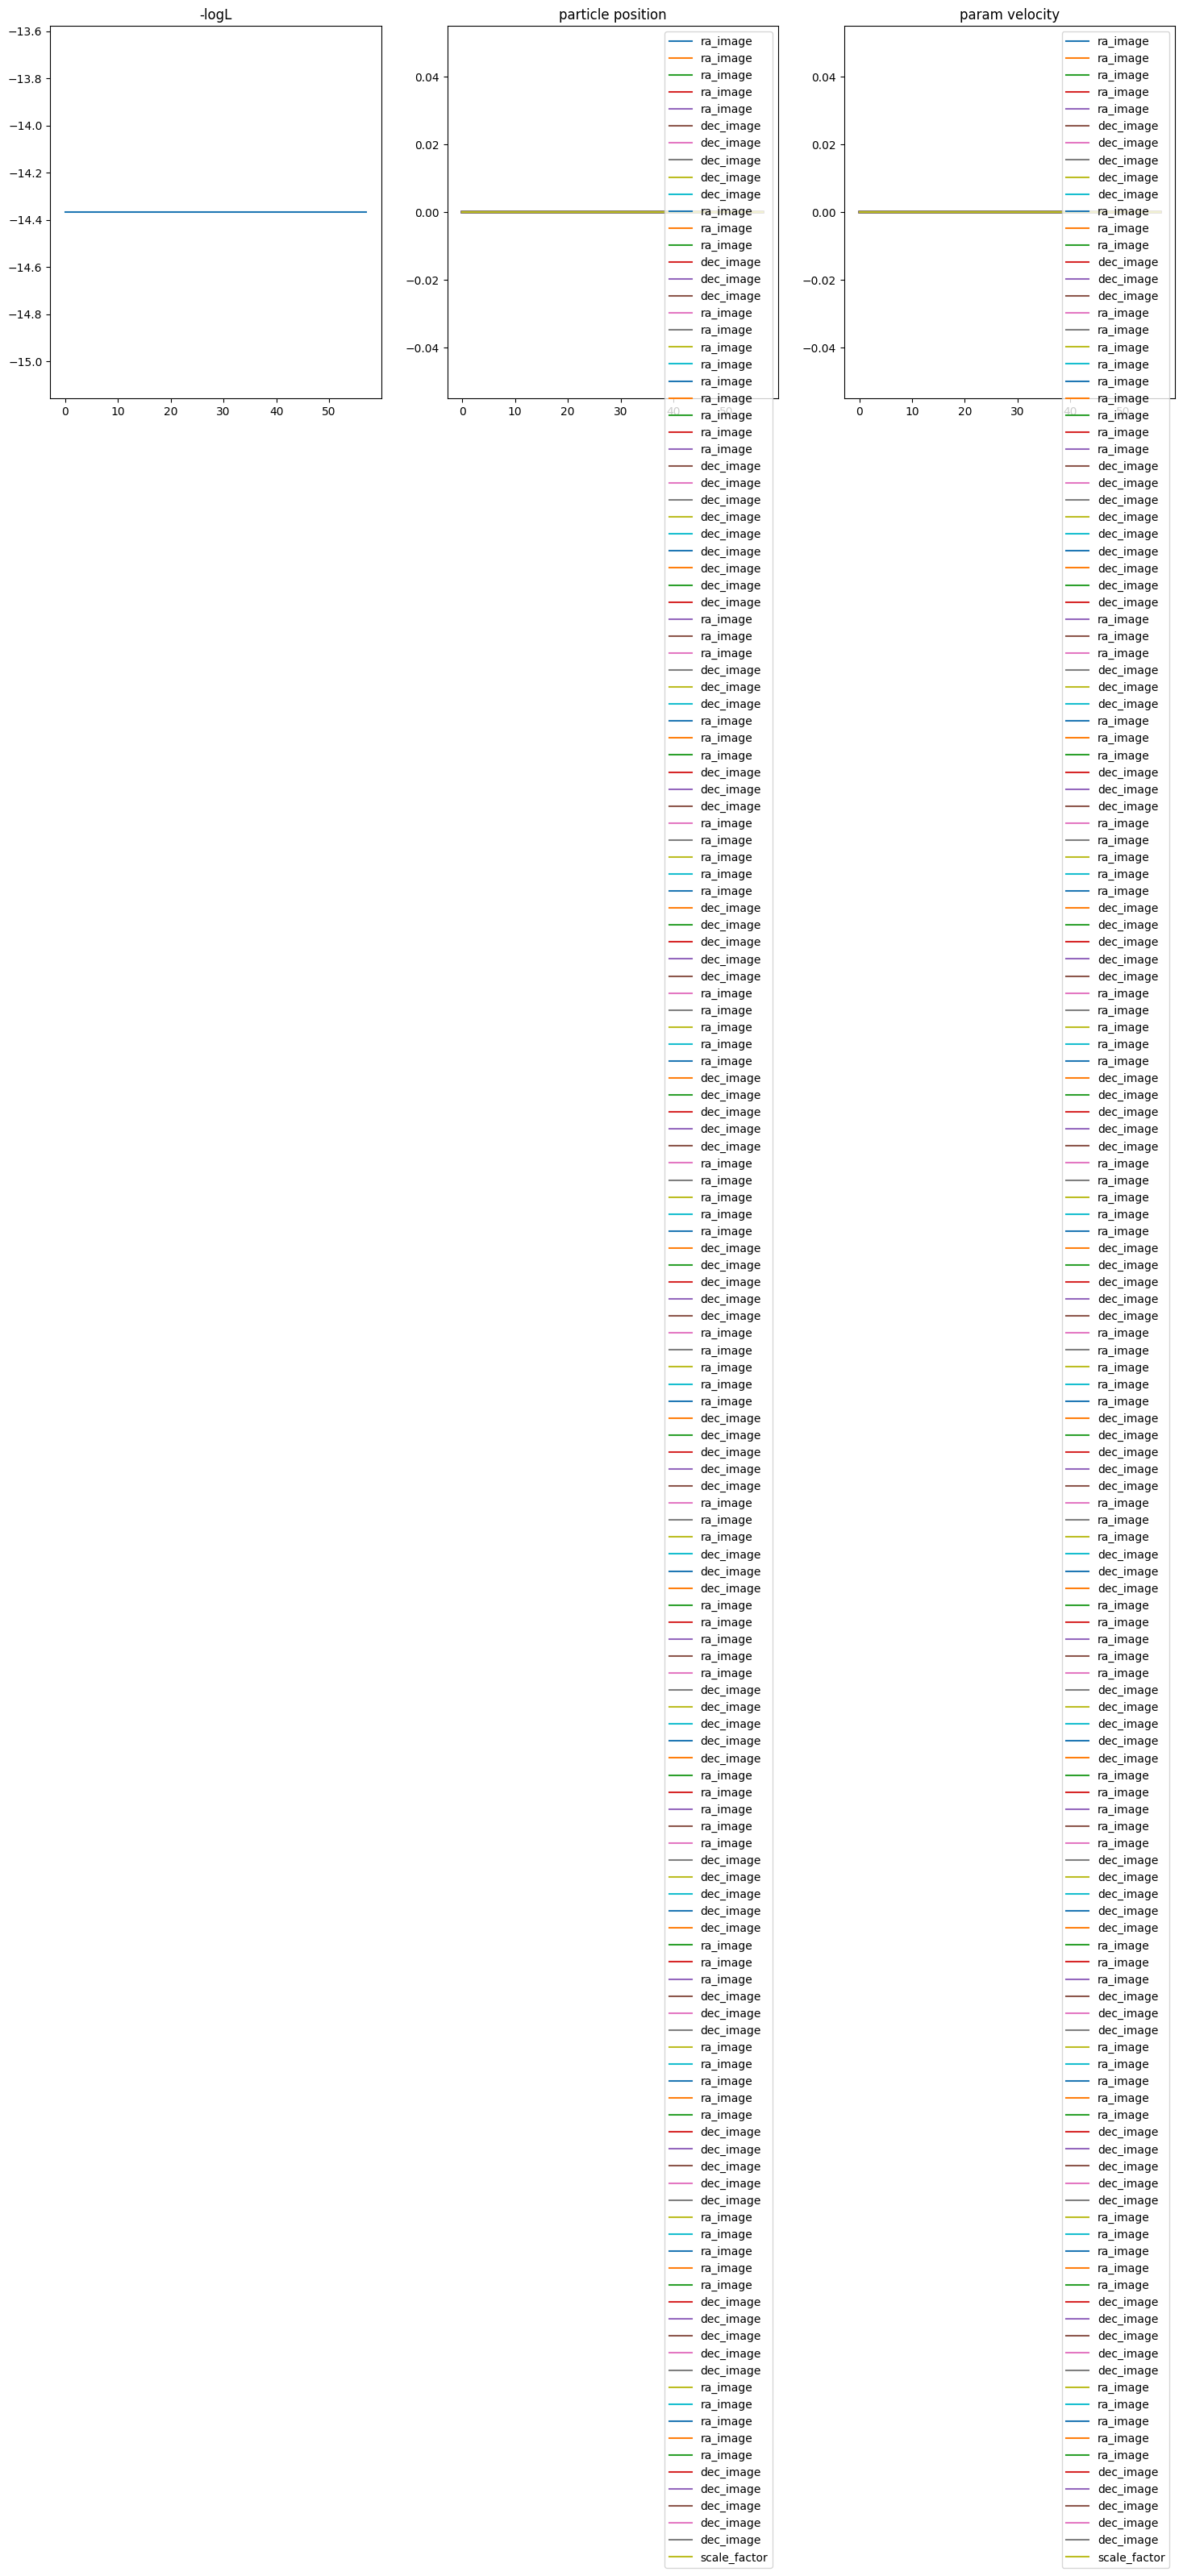

<Figure size 640x480 with 0 Axes>

In [86]:
kwargs_result = fitting_seq.best_fit(bijective=True)
args_result = fitting_seq.param_class.kwargs2args(**kwargs_result)
logL = fitting_seq.likelihoodModule.logL(args_result, verbose=True)

from lenstronomy.Plots import chain_plot
for i in range(len(chain_list_pso)):
    chain_plot.plot_chain_list(chain_list_pso, i)

print("kwargs_results", kwargs_result)

## MCMC posterior sampling

In [79]:
#and now we run the MCMC
fitting_kwargs_list = [
    ['MCMC', {'n_burn': 200, 'n_run': 400, 'walkerRatio': 10,'sigma_scale': 0.1}]
]
chain_list_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list)

kwargs_result = fitting_seq.best_fit()

MCMC selected. Sampling with default option emcee.


  1%|          | 4/600 [21:08<54:10:14, 327.21s/it]Traceback (most recent call last):
  File "C:\Users\earth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\emcee\ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\users\earth\documents\graduate school\stony brook\research\lenstronomy\lenstronomy\Sampling\likelihood.py", line 352, in logL
    return self.log_likelihood(kwargs_return, verbose=verbose)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\users\earth\documents\graduate school\stony brook\research\lenstronomy\lenstronomy\Sampling\likelihood.py", line 428, in log_likelihood
    logL += self._position_likelihood.logL(
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\users\earth\documents\graduate school\stony brook\research\lenstronomy\lenstronomy\Sampling\Likelihoods\position_likelih

emcee: Exception while calling your likelihood function:
  params: [ 13.51800199  -1.02250889   3.95134002  -9.05116571  -1.08148183
  15.67386202 -12.18967791 -10.84978004   3.22285785  -0.35189286
  18.26667496  -6.30683489  -2.51169695  13.61745598   2.83162775
   0.70134022  -9.54435807  11.91248532   8.50210065  10.28174906
   9.13965971   9.75455934  11.0342387   -4.68880916  -0.08779261
 -16.31664913   6.11067809  10.65829989   9.86445622   8.80513992
   9.14880372  -3.8990618    6.62124353   0.78381872   1.24660229
 -19.48302723 -16.46646918  20.73345948  -1.82210164  11.19806086
  -1.96813367  20.01660584  16.42232219 -21.6011567    3.95225229
 -12.58546394  16.53974083  -1.34510174   9.81179123  -4.32487778
  -2.19474781   9.87379884 -16.21847168 -10.28405832   2.69059236
   1.20153969 -15.47809066   4.52530979  -7.51384758  11.04205434
   0.71010058 -16.94222559  14.66641626  13.80064412  -3.0022127
   0.48054751  -3.94633869  11.97841894   8.23498421  -2.95988035
  -1.31739

KeyboardInterrupt: 

In [ ]:
## we want the logL (log likelihood) to stay fairly flat across the plot, that means its a decent guess.
chain_plot.plot_chain_list(chain_list_mcmc)

## Post-processing the chains 

In [ ]:
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list_mcmc[0]

print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])

# import the parameter handling class #
from lenstronomy.Sampling.parameters import Param
import lenstronomy.Util.param_util as param_util
# make instance of parameter class with given model options, constraints and fixed parameters
# this allows to recover the full parameters of all model components, not just the ones being sampled.

param = Param(kwargs_model, fixed_lens, kwargs_fixed_ps=fixed_ps, kwargs_fixed_special=fixed_special, 
              kwargs_lens_init=kwargs_result['kwargs_lens'], **kwargs_constraints)
# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()

lensModel = LensModel(kwargs_model['lens_model_list'])
lensModelExtensions = LensModelExtensions(lensModel=lensModel)
print("parameter values: ", param)

In [ ]:
np.save('samples_mcmc_cluster', samples_mcmc)
np.save('sampler_type_cluster', sampler_type)
np.save('param_cluster', param)
np.save('lens_model_list_cluster', lens_model_list)
np.save('kwargs_constraints_cluster', kwargs_constraints)
np.save('special_params_cluster', special_params)
for i in range(num_sources):
    np.save('x_imgs_cluster'+str(i), x_imgs[i])
    np.save('y_imgs_cluster'+str(i), y_imgs[i])
    np.save('label_list_cluster'+str(i), label_lists[i])
np.save('param_mcmc_cluster', param_mcmc)
np.save('dist_mcmc_cluster', dist_mcmc)
np.save('num_param_cluster', num_param)
np.save('param_list_cluster', param_list)
np.save('kwargs_result_cluster', kwargs_result)
for i in range(4):
    np.save('chain_list_mcmc_cluster'+str(i), chain_list_mcmc[0][i])

In [ ]:
num_sources_ = 20

samples_mcmc_ = np.load('samples_mcmc_cluster.npy')
sampler_type_ = np.load('sampler_type_cluster.npy')
lens_model_list_ = np.load('lens_model_list_cluster.npy')
x_imgs_ = []
label_lists_ = []
for i in range(num_sources_):
    x_imgs_.append(np.load('x_imgs_cluster'+str(i)+'.npy'))
    label_lists_.append(np.load('label_list_cluster'+str(i)+'.npy'))
param_mcmc_ = np.load('param_mcmc_cluster.npy')
dist_mcmc_ = np.load('dist_mcmc_cluster.npy')
num_param_ = np.load('num_param_cluster.npy')
param_list_ = np.load('param_list_cluster.npy')
param_ = np.load('param_cluster.npy', allow_pickle=True)
kwargs_constraints_ = np.load('kwargs_constraints_cluster.npy', allow_pickle=True)
special_params_ = np.load('special_params_cluster.npy', allow_pickle=True)
kwargs_result_ = np.load('kwargs_result_cluster.npy', allow_pickle=True)
chain_list_mcmc_ = []
for i in range(4):
    chain_list_mcmc_.append(np.load('chain_list_mcmc_cluster'+str(i)+'.npy'))


In [ ]:
param_ = np.ndarray.tolist(param_)
samples_mcmc_ = np.ndarray.tolist(samples_mcmc_)
sampler_type_ = np.ndarray.tolist(sampler_type_)
lens_model_list_ = np.ndarray.tolist(lens_model_list_)
for i in range(len(x_imgs_)):
    x_imgs_[i] = np.ndarray.tolist(x_imgs_[i])

for i in range(len(label_lists_)):
    label_lists_[i] = np.ndarray.tolist(label_lists_[i])
param_mcmc_ = np.ndarray.tolist(param_mcmc_)
dist_mcmc_ = np.ndarray.tolist(dist_mcmc_)
num_param_ = np.ndarray.tolist(num_param_)
param_list_ = np.ndarray.tolist(param_list_)
kwargs_constraints_ = np.ndarray.tolist(kwargs_constraints_)
special_params_ = np.ndarray.tolist(special_params_)
kwargs_result_ = np.ndarray.tolist(kwargs_result_)
for i in range(4):
    chain_list_mcmc_[i] = np.ndarray.tolist(chain_list_mcmc_[i])

In [ ]:
labels_new = []
for i in range(num_cluster_members):
    labels_new.extend(['sigma0_lens_'+str(i), 'Ra_lens_'+str(i), 'Rs_lens_'+str(i), 'e1_lens_'+str(i), 'e2_lens_'+str(i), 'center_x_lens'+str(i), 'center_y_lens'+str(i)])
labels_new.extend(['Rs_nfw_lens', 'alphaRs_nfw_lens', 'e1_nfw_lens', 'e2_nfw_lens', 'center_x_nfw_lens', 'center_y_nfw_lens'])

lenstronomy_clusters_functions.clusters_functions.real_image_pos_labels(num_sources, x_imgs, labels_new, label_lists, image_position_likelihood=True)
lenstronomy_clusters_functions.clusters_functions.flux_ratio_labels(num_sources, x_imgs, labels_new, label_lists, flux_ratio_likelihood=False)
lenstronomy_clusters_functions.clusters_functions.source_size_labels(kwargs_constraints, labels_new, special_params=special_params)
lenstronomy_clusters_functions.clusters_functions.time_delay_labels(labels_new, time_delay_likelihood=True)

print(labels_new)

In [ ]:
new_chain = []
mcmc_new_list_cluster = []

mcmc_new_list_cluster = lenstronomy_clusters_functions.clusters_functions.samples2posterior_plot(samples=samples_mcmc_, mcmc_list=mcmc_new_list_cluster, param_class=param_, lens_model_list=lens_model_list_, kwargs_constraints=kwargs_constraints_, special_params=special_params_, image_position_likelihood=True, with_flux_ratios=False, time_delay_likelihood=False)

In [ ]:
# np.save('mcmc_new_list_cluster', mcmc_new_list_cluster)

In [ ]:
mcmc_new_list_cluster_ = np.load('mcmc_new_list_cluster.npy')

In [ ]:
# import code for legend on corner plot
import matplotlib.lines as mlines

# purple_line = mlines.Line2D([], [], color='purple', label=str(num_sources_data)+" Sources, varied z")
blue_line = mlines.Line2D([], [], color='blue', label='Clusters, const z')

In [ ]:
samples_cluster = np.array(mcmc_new_list_cluster[269500:308000])

figure = corner.corner(samples_cluster, labels=labels_new, color='blue', show_titles=True) # fig=plot should put the one with reduced data and the full one on top of each other... reduced = blue, original = gray

plt.legend(handles=[blue_line], bbox_to_anchor=(-2, 4., 1., .0), loc=1)


In [ ]:
# input truth time-delay distance [Mpc]
lensCosmo.ddt